In [1]:
from sklearn.decomposition import TruncatedSVD

In [2]:
import gensim
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd
df_data = pd.read_csv('../data/canada_data_select.csv')
df_data.drop_duplicates(['ad_id', 'locations', 'phone_id', 'title', 'body'], inplace=True)
df_data.reset_index(inplace=True)

all_words = []


stop_words = set(stopwords.words('english'))
content = []
for index, row in df_data.iterrows():
    c = ''
    # if type(row['title']) == type(' '):
    # 	c = c + row['title']
    if type(row['body']) == type(' '):
        c = c + row['body']
    c = re.sub(r'\d+', '', c)
    c = re.sub(r'[^\x00-\x7F]+','', c)
    cleanr = re.compile('<.*?>')
    c = re.sub(cleanr, '', c)
    c = re.sub(r"[^a-zA-Z0-9.?]+", ' ', c)
    content.append(c.lower())
    if index%10000 == 0:
        print (index)

df_data = pd.read_csv('../data/ht_unique_unique_ads_cosine.csv')
for index, row in df_data.iterrows():
    c = ''
    # if type(row['title']) == type(' '):
    # 	c = c + row['title']
    if type(row['body']) == type(' '):
        c = c + row['body']
    c = re.sub(r'\d+', '', c)
    c = re.sub(r'[^\x00-\x7F]+','', c)
    cleanr = re.compile('<.*?>')
    c = re.sub(cleanr, '', c)
    c = re.sub(r"[^a-zA-Z0-9.?]+", ' ', c)
    content.append(c.lower())
    
# print ("Writing to file....")
# with open('../data/canada/only_text_train1.txt', 'a') as f:
#     f.writelines(content)

print (len(content)) 

def filter_words(word):
#     print (word)
    word = str(word)
    if any(not x.isalpha() for x in word):
        # print word
        return True
#     if word in stop_words:
#         return True
    if len(word) < 3:
        return True

    return False

words_total = []
for index, sent in enumerate(content):
#     print (index)
    sent_words = []
#     if index == 0 :
#         continue
#     print index
    try:
        sentences = nltk.sent_tokenize(sent)
    except Exception as e:
        print (e)
#         print para
#         time.sleep(5)
        continue
    
    for ind, sen in enumerate(sentences):
        words = list(nltk.word_tokenize(sen))

        for w in words:
            # if w in punctuation or w in stopwords:
            w = re.sub('\W+','', w)
            if filter_words(w):
#                 print (w)
                continue
            words_total.append(w)
            sent_words.append(w.lower())
#     print (sent_words)
    if sent_words:
#         print (index)
        all_words.append(sent_words)
model = gensim.models.Word2Vec(all_words, window=5, size=100, min_count=2)
# model.save('gutenberg_clean/word2vec/model_trafficking_10k_1.bin')
# model.wv.save_word2vec_format('gutenberg_clean/word2vec/model_trafficking_10k_1.emd')
word_vectors = model.wv
# print (len(all_words))


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
574810


In [3]:
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

def filter_words(word):
    word = str(word)
    if any(not x.isalpha() for x in word):
        return True

    elif len(word) < 3:
        return True

    return False

df_data = pd.read_csv('../data/ht_unique_unique_ads_cosine.csv')
content = []

stop_words = set(stopwords.words('english'))
for index, row in df_data.iterrows():
    c = ''
    # if type(row['title']) == type(' '):
    # 	c = c + row['title']
    if type(row['body']) == type(' '):
        c = c + row['body']
    # c = row['title'] + ' ' + row['body']
    c = re.sub(r'\d+', '', c)
    if type(row['Name']) == type(''):
        name = row['Name'].split(';')
        for n in name:
            name_regex = re.compile(re.escape(n), re.IGNORECASE)
            c = name_regex.sub('', c)
        c = re.sub(r'[^\x00-\x7F]+',' ', c)
        cleanr = re.compile('<.*?>')
        c = re.sub(cleanr, '', c)
    content.append(c)
df_data['content_p'] = content

filtered_content = []
all_words = []

for index, sent in enumerate(content):
    sent_words = []
    
    try:
        sentences = nltk.sent_tokenize(sent)
    except Exception as e:
        print (e)
        continue
    
    for ind, sen in enumerate(sentences):
        words = list(nltk.word_tokenize(sen))

        for w in words:
            w = re.sub('\W+','', w)
            if filter_words(w):

                continue
            sent_words.append(w.lower())

    if not sent_words:
        df_data.drop(index, inplace=True)
    else:
        all_words.append(sent_words)
        filtered_content.append(' '.join(sent_words))
    
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1), norm='l2', 
     stop_words=stop_words, min_df=2, max_df=0.8)

bigram_matrix = vectorizer.fit_transform(filtered_content)
features_col = vectorizer.get_feature_names()
bigram_dense_matrix = np.asarray(bigram_matrix.todense())

In [4]:
vectors = np.zeros((len(all_words), 100), dtype=float)
total_not_found = 0.0
not_found_count = 0.0

for ind, word_tokens in enumerate(all_words):
    not_found_count = 0
    for word in word_tokens:
        weight = 0.0
        try:
            word_index = features_col.index(word)
            weight = bigram_dense_matrix[ind][word_index]
        except:
#             print (word)
            not_found_count += 1
        if word in word_vectors and weight != 0.0:
            vectors[ind] += (weight * 10 * word_vectors[word])

    total_not_found += not_found_count
    print ("Not Found : {}".format(not_found_count/len(word_tokens)))


Not Found : 0.41935483870967744
Not Found : 0.4426229508196721
Not Found : 0.3902439024390244
Not Found : 0.3875
Not Found : 0.38181818181818183
Not Found : 0.375
Not Found : 0.10714285714285714
Not Found : 0.09090909090909091
Not Found : 0.09375
Not Found : 0.09375
Not Found : 0.09375
Not Found : 0.09375
Not Found : 0.09375
Not Found : 0.09375
Not Found : 0.09375
Not Found : 0.37640449438202245
Not Found : 0.3148148148148148
Not Found : 0.36129032258064514
Not Found : 0.36774193548387096
Not Found : 0.363013698630137
Not Found : 0.37012987012987014
Not Found : 0.31666666666666665
Not Found : 0.3548387096774194
Not Found : 0.35135135135135137
Not Found : 0.36538461538461536
Not Found : 0.18
Not Found : 0.21428571428571427
Not Found : 0.17647058823529413
Not Found : 0.2033898305084746
Not Found : 0.4
Not Found : 0.4074074074074074
Not Found : 0.425
Not Found : 0.29310344827586204
Not Found : 0.32142857142857145
Not Found : 0.3157894736842105
Not Found : 0.32142857142857145
Not Found : 0

Not Found : 0.22033898305084745
Not Found : 0.3333333333333333
Not Found : 0.1
Not Found : 0.18518518518518517
Not Found : 0.27450980392156865
Not Found : 0.1346153846153846
Not Found : 0.3
Not Found : 0.32
Not Found : 0.40384615384615385
Not Found : 0.06
Not Found : 0.07407407407407407
Not Found : 0.10416666666666667
Not Found : 0.06779661016949153
Not Found : 0.14285714285714285
Not Found : 0.3333333333333333
Not Found : 0.4142857142857143
Not Found : 0.3404255319148936
Not Found : 0.31343283582089554
Not Found : 0.24
Not Found : 0.3125
Not Found : 0.391304347826087
Not Found : 0.35384615384615387
Not Found : 0.2786885245901639
Not Found : 0.29411764705882354
Not Found : 0.3448275862068966
Not Found : 0.22727272727272727
Not Found : 0.3191489361702128
Not Found : 0.36538461538461536
Not Found : 0.33962264150943394
Not Found : 0.21951219512195122
Not Found : 0.41304347826086957
Not Found : 0.27586206896551724
Not Found : 0.3333333333333333
Not Found : 0.2459016393442623
Not Found : 0.

Not Found : 0.444015444015444
Not Found : 0.23529411764705882
Not Found : 0.22580645161290322
Not Found : 0.20754716981132076
Not Found : 0.25
Not Found : 0.23333333333333334
Not Found : 0.20833333333333334
Not Found : 0.2391304347826087
Not Found : 0.37037037037037035
Not Found : 0.2916666666666667
Not Found : 0.4444444444444444
Not Found : 0.3225806451612903
Not Found : 0.0
Not Found : 0.3333333333333333
Not Found : 0.38461538461538464
Not Found : 0.40476190476190477
Not Found : 0.23809523809523808
Not Found : 0.5689655172413793
Not Found : 0.29411764705882354
Not Found : 0.39285714285714285
Not Found : 0.3793103448275862
Not Found : 0.37142857142857144
Not Found : 0.3870967741935484
Not Found : 0.4642857142857143
Not Found : 0.30303030303030304
Not Found : 0.3409090909090909
Not Found : 0.26666666666666666
Not Found : 0.23333333333333334
Not Found : 0.2692307692307692
Not Found : 0.3178294573643411
Not Found : 0.23333333333333334
Not Found : 0.2545454545454545
Not Found : 0.45283018

Not Found : 0.2708333333333333
Not Found : 0.4074074074074074
Not Found : 0.2
Not Found : 0.16129032258064516
Not Found : 0.20689655172413793
Not Found : 0.39285714285714285
Not Found : 0.24390243902439024
Not Found : 0.375
Not Found : 0.2413793103448276
Not Found : 0.3235294117647059
Not Found : 0.2222222222222222
Not Found : 0.5483870967741935
Not Found : 0.2682926829268293
Not Found : 0.15789473684210525
Not Found : 0.2653061224489796
Not Found : 0.38235294117647056
Not Found : 0.2923076923076923
Not Found : 0.23255813953488372
Not Found : 0.1568627450980392
Not Found : 0.18604651162790697
Not Found : 0.26785714285714285
Not Found : 0.2786885245901639
Not Found : 0.35
Not Found : 0.2564102564102564
Not Found : 0.13793103448275862
Not Found : 0.2619047619047619
Not Found : 0.3492063492063492
Not Found : 0.25
Not Found : 0.43243243243243246
Not Found : 0.09090909090909091
Not Found : 0.2978723404255319
Not Found : 0.2692307692307692
Not Found : 0.30434782608695654
Not Found : 0.269230

Not Found : 0.2894736842105263
Not Found : 0.2
Not Found : 0.34615384615384615
Not Found : 0.3333333333333333
Not Found : 0.25
Not Found : 0.25
Not Found : 0.225
Not Found : 0.1590909090909091
Not Found : 0.16666666666666666
Not Found : 0.1794871794871795
Not Found : 0.2222222222222222
Not Found : 0.20454545454545456
Not Found : 0.20454545454545456
Not Found : 0.18
Not Found : 0.3333333333333333
Not Found : 0.2727272727272727
Not Found : 0.30612244897959184
Not Found : 0.28888888888888886
Not Found : 0.35135135135135137
Not Found : 0.14893617021276595
Not Found : 0.23529411764705882
Not Found : 0.23529411764705882
Not Found : 0.1864406779661017
Not Found : 0.1111111111111111
Not Found : 0.328125
Not Found : 0.17647058823529413
Not Found : 0.12
Not Found : 0.19148936170212766
Not Found : 0.2222222222222222
Not Found : 0.30303030303030304
Not Found : 0.2
Not Found : 0.23684210526315788
Not Found : 0.2962962962962963
Not Found : 0.10638297872340426
Not Found : 0.1891891891891892
Not Found

Not Found : 0.07407407407407407
Not Found : 0.08771929824561403
Not Found : 0.18518518518518517
Not Found : 0.14285714285714285
Not Found : 0.1
Not Found : 0.11627906976744186
Not Found : 0.18181818181818182
Not Found : 0.06896551724137931
Not Found : 0.1702127659574468
Not Found : 0.2222222222222222
Not Found : 0.046511627906976744
Not Found : 0.05405405405405406
Not Found : 0.2127659574468085
Not Found : 0.06976744186046512
Not Found : 0.045454545454545456
Not Found : 0.24390243902439024
Not Found : 0.0967741935483871
Not Found : 0.15217391304347827
Not Found : 0.08823529411764706
Not Found : 0.07692307692307693
Not Found : 0.2
Not Found : 0.20930232558139536
Not Found : 0.19607843137254902
Not Found : 0.20512820512820512
Not Found : 0.2619047619047619
Not Found : 0.1956521739130435
Not Found : 0.30612244897959184
Not Found : 0.14285714285714285
Not Found : 0.2647058823529412
Not Found : 0.16
Not Found : 0.08888888888888889
Not Found : 0.3137254901960784
Not Found : 0.142857142857142

Not Found : 0.2641509433962264
Not Found : 0.25
Not Found : 0.15384615384615385
Not Found : 0.375
Not Found : 0.24528301886792453
Not Found : 0.1282051282051282
Not Found : 0.32432432432432434
Not Found : 0.13333333333333333
Not Found : 0.2222222222222222
Not Found : 0.2857142857142857
Not Found : 0.25
Not Found : 0.3114754098360656
Not Found : 0.21052631578947367
Not Found : 0.10344827586206896
Not Found : 0.17777777777777778
Not Found : 0.17073170731707318
Not Found : 0.43478260869565216
Not Found : 0.2
Not Found : 0.3684210526315789
Not Found : 0.34615384615384615
Not Found : 0.125
Not Found : 0.21428571428571427
Not Found : 0.13043478260869565
Not Found : 0.2222222222222222
Not Found : 0.18181818181818182
Not Found : 0.4
Not Found : 0.2830188679245283
Not Found : 0.1951219512195122
Not Found : 0.21052631578947367
Not Found : 0.13953488372093023
Not Found : 0.18181818181818182
Not Found : 0.2553191489361702
Not Found : 0.275
Not Found : 0.36507936507936506
Not Found : 0.346153846153

Not Found : 0.2702702702702703
Not Found : 0.1875
Not Found : 0.23684210526315788
Not Found : 0.41509433962264153
Not Found : 0.17307692307692307
Not Found : 0.3709677419354839
Not Found : 0.35555555555555557
Not Found : 0.2
Not Found : 0.22580645161290322
Not Found : 0.3333333333333333
Not Found : 0.34375
Not Found : 0.07692307692307693
Not Found : 0.25
Not Found : 0.38333333333333336
Not Found : 0.3111111111111111
Not Found : 0.5517241379310345
Not Found : 0.17647058823529413
Not Found : 0.375
Not Found : 0.3333333333333333
Not Found : 0.30434782608695654
Not Found : 0.225
Not Found : 0.35135135135135137
Not Found : 0.3617021276595745
Not Found : 0.275
Not Found : 0.3389830508474576
Not Found : 0.32142857142857145
Not Found : 0.2
Not Found : 0.28
Not Found : 0.2608695652173913
Not Found : 0.09090909090909091
Not Found : 0.2682926829268293
Not Found : 0.35714285714285715
Not Found : 0.3448275862068966
Not Found : 0.3103448275862069
Not Found : 0.34545454545454546
Not Found : 0.2678571

Not Found : 0.3333333333333333
Not Found : 0.16666666666666666
Not Found : 0.27450980392156865
Not Found : 0.375
Not Found : 0.4418604651162791
Not Found : 0.44
Not Found : 0.47058823529411764
Not Found : 0.375
Not Found : 0.2222222222222222
Not Found : 0.45161290322580644
Not Found : 0.4807692307692308
Not Found : 0.3148148148148148
Not Found : 0.46153846153846156
Not Found : 0.2
Not Found : 0.27586206896551724
Not Found : 0.2631578947368421
Not Found : 0.34615384615384615
Not Found : 0.25
Not Found : 0.2857142857142857
Not Found : 0.19444444444444445
Not Found : 0.125
Not Found : 0.5294117647058824
Not Found : 0.1
Not Found : 0.24074074074074073
Not Found : 0.3
Not Found : 0.40425531914893614
Not Found : 0.34545454545454546
Not Found : 0.0
Not Found : 0.23076923076923078
Not Found : 0.25
Not Found : 0.21621621621621623
Not Found : 0.34615384615384615
Not Found : 0.375
Not Found : 0.3404255319148936
Not Found : 0.15555555555555556
Not Found : 0.25
Not Found : 0.19148936170212766
Not F

Not Found : 0.39344262295081966
Not Found : 0.4067796610169492
Not Found : 0.2692307692307692
Not Found : 0.2857142857142857
Not Found : 0.5111111111111111
Not Found : 0.3076923076923077
Not Found : 0.023255813953488372
Not Found : 0.4
Not Found : 0.35384615384615387
Not Found : 0.058823529411764705
Not Found : 0.17647058823529413
Not Found : 0.2222222222222222
Not Found : 0.391304347826087
Not Found : 0.06451612903225806
Not Found : 0.5111111111111111
Not Found : 0.19230769230769232
Not Found : 0.1875
Not Found : 0.2
Not Found : 0.1875
Not Found : 0.20408163265306123
Not Found : 0.2222222222222222
Not Found : 0.3695652173913043
Not Found : 0.23529411764705882
Not Found : 0.2549019607843137
Not Found : 0.25806451612903225
Not Found : 0.35185185185185186
Not Found : 0.3181818181818182
Not Found : 0.25
Not Found : 0.25
Not Found : 0.29545454545454547
Not Found : 0.4
Not Found : 0.2
Not Found : 0.3333333333333333
Not Found : 0.2692307692307692
Not Found : 0.3333333333333333
Not Found : 0.

Not Found : 0.34
Not Found : 0.14285714285714285
Not Found : 0.45454545454545453
Not Found : 0.2
Not Found : 0.14814814814814814
Not Found : 0.21621621621621623
Not Found : 0.3
Not Found : 0.24390243902439024
Not Found : 0.22413793103448276
Not Found : 0.38235294117647056
Not Found : 0.46153846153846156
Not Found : 0.2692307692307692
Not Found : 0.23404255319148937
Not Found : 0.23529411764705882
Not Found : 0.30952380952380953
Not Found : 0.3064516129032258
Not Found : 0.3114754098360656
Not Found : 0.13725490196078433
Not Found : 0.34146341463414637
Not Found : 0.2903225806451613
Not Found : 0.42857142857142855
Not Found : 0.33557046979865773
Not Found : 0.17142857142857143
Not Found : 0.22857142857142856
Not Found : 0.19444444444444445
Not Found : 0.23529411764705882
Not Found : 0.2916666666666667
Not Found : 0.3
Not Found : 0.2857142857142857
Not Found : 0.23255813953488372
Not Found : 0.23076923076923078
Not Found : 0.07142857142857142
Not Found : 0.0
Not Found : 0.2
Not Found : 0

Not Found : 0.3333333333333333
Not Found : 0.2222222222222222
Not Found : 0.13333333333333333
Not Found : 0.0
Not Found : 0.31666666666666665
Not Found : 0.2037037037037037
Not Found : 0.06
Not Found : 0.3770491803278688
Not Found : 0.3269230769230769
Not Found : 0.2926829268292683
Not Found : 0.38095238095238093
Not Found : 0.41379310344827586
Not Found : 0.0
Not Found : 0.046511627906976744
Not Found : 0.13953488372093023
Not Found : 0.08333333333333333
Not Found : 0.25675675675675674
Not Found : 0.30357142857142855
Not Found : 0.3
Not Found : 0.2777777777777778
Not Found : 0.45454545454545453
Not Found : 0.17857142857142858
Not Found : 0.1111111111111111
Not Found : 0.25757575757575757
Not Found : 0.2826086956521739
Not Found : 0.37037037037037035
Not Found : 0.1836734693877551
Not Found : 0.20454545454545456
Not Found : 0.3111111111111111
Not Found : 0.3793103448275862
Not Found : 0.1794871794871795
Not Found : 0.1111111111111111
Not Found : 0.14754098360655737
Not Found : 0.290909

Not Found : 0.22857142857142856
Not Found : 0.20930232558139536
Not Found : 0.24074074074074073
Not Found : 0.34375
Not Found : 0.3333333333333333
Not Found : 0.17391304347826086
Not Found : 0.32727272727272727
Not Found : 0.1794871794871795
Not Found : 0.28
Not Found : 0.28888888888888886
Not Found : 0.18518518518518517
Not Found : 0.4782608695652174
Not Found : 0.2857142857142857
Not Found : 0.3684210526315789
Not Found : 0.15384615384615385
Not Found : 0.24074074074074073
Not Found : 0.23529411764705882
Not Found : 0.21052631578947367
Not Found : 0.24444444444444444
Not Found : 0.25925925925925924
Not Found : 0.39215686274509803
Not Found : 0.2222222222222222
Not Found : 0.46511627906976744
Not Found : 0.20930232558139536
Not Found : 0.30434782608695654
Not Found : 0.4074074074074074
Not Found : 0.32
Not Found : 0.21875
Not Found : 0.42857142857142855
Not Found : 0.325
Not Found : 0.24074074074074073
Not Found : 0.3333333333333333
Not Found : 0.16129032258064516
Not Found : 0.357142

Not Found : 0.15384615384615385
Not Found : 0.20833333333333334
Not Found : 0.1702127659574468
Not Found : 0.3728813559322034
Not Found : 0.13043478260869565
Not Found : 0.358974358974359
Not Found : 0.3269230769230769
Not Found : 0.3492063492063492
Not Found : 0.34375
Not Found : 0.36363636363636365
Not Found : 0.15217391304347827
Not Found : 0.0
Not Found : 0.325
Not Found : 0.2857142857142857
Not Found : 0.20833333333333334
Not Found : 0.3488372093023256
Not Found : 0.3442622950819672
Not Found : 0.27450980392156865
Not Found : 0.3888888888888889
Not Found : 0.3
Not Found : 0.10714285714285714
Not Found : 0.4166666666666667
Not Found : 0.17142857142857143
Not Found : 0.32142857142857145
Not Found : 0.23684210526315788
Not Found : 0.3018867924528302
Not Found : 0.0
Not Found : 0.21875
Not Found : 0.2857142857142857
Not Found : 0.3392857142857143
Not Found : 0.3783783783783784
Not Found : 0.3235294117647059
Not Found : 0.16666666666666666
Not Found : 0.3684210526315789
Not Found : 0.1

Not Found : 0.3125
Not Found : 0.4
Not Found : 0.4032258064516129
Not Found : 0.38461538461538464
Not Found : 0.26153846153846155
Not Found : 0.13636363636363635
Not Found : 0.21428571428571427
Not Found : 0.2692307692307692
Not Found : 0.23529411764705882
Not Found : 0.3125
Not Found : 0.17391304347826086
Not Found : 0.36
Not Found : 0.0
Not Found : 0.34375
Not Found : 0.23076923076923078
Not Found : 0.25
Not Found : 0.2702702702702703
Not Found : 0.11764705882352941
Not Found : 0.2
Not Found : 0.30303030303030304
Not Found : 0.05405405405405406
Not Found : 0.35555555555555557
Not Found : 0.23809523809523808
Not Found : 0.23529411764705882
Not Found : 0.30357142857142855
Not Found : 0.32608695652173914
Not Found : 0.24390243902439024
Not Found : 0.14583333333333334
Not Found : 0.3076923076923077
Not Found : 0.11428571428571428
Not Found : 0.35185185185185186
Not Found : 0.25
Not Found : 0.29411764705882354
Not Found : 0.3076923076923077
Not Found : 0.08333333333333333
Not Found : 0.37

Not Found : 0.2857142857142857
Not Found : 0.2558139534883721
Not Found : 0.2127659574468085
Not Found : 0.15789473684210525
Not Found : 0.30357142857142855
Not Found : 0.23529411764705882
Not Found : 0.2222222222222222
Not Found : 0.2727272727272727
Not Found : 0.2962962962962963
Not Found : 0.20930232558139536
Not Found : 0.12962962962962962
Not Found : 0.2
Not Found : 0.2903225806451613
Not Found : 0.23333333333333334
Not Found : 0.35294117647058826
Not Found : 0.23255813953488372
Not Found : 0.2830188679245283
Not Found : 0.29310344827586204
Not Found : 0.4166666666666667
Not Found : 0.3157894736842105
Not Found : 0.3404255319148936
Not Found : 0.23809523809523808
Not Found : 0.3333333333333333
Not Found : 0.2692307692307692
Not Found : 0.28125
Not Found : 0.2647058823529412
Not Found : 0.14285714285714285
Not Found : 0.4
Not Found : 0.3333333333333333
Not Found : 0.3333333333333333
Not Found : 0.2653061224489796
Not Found : 0.15217391304347827
Not Found : 0.22950819672131148
Not F

Not Found : 0.2413793103448276
Not Found : 0.20930232558139536
Not Found : 0.16
Not Found : 0.25
Not Found : 0.37254901960784315
Not Found : 0.4772727272727273
Not Found : 0.2727272727272727
Not Found : 0.34615384615384615
Not Found : 0.22448979591836735
Not Found : 0.2727272727272727
Not Found : 0.3023255813953488
Not Found : 0.2765957446808511
Not Found : 0.19444444444444445
Not Found : 0.25
Not Found : 0.125
Not Found : 0.0
Not Found : 0.26666666666666666
Not Found : 0.3684210526315789
Not Found : 0.2916666666666667
Not Found : 0.3333333333333333
Not Found : 0.2033898305084746
Not Found : 0.5
Not Found : 0.4375
Not Found : 0.328125
Not Found : 0.4
Not Found : 0.2826086956521739
Not Found : 0.24242424242424243
Not Found : 0.18181818181818182
Not Found : 0.3170731707317073
Not Found : 0.3076923076923077
Not Found : 0.21568627450980393
Not Found : 0.21052631578947367
Not Found : 0.21052631578947367
Not Found : 0.25
Not Found : 0.3389830508474576
Not Found : 0.19444444444444445
Not Foun

Not Found : 0.3225806451612903
Not Found : 0.3492063492063492
Not Found : 0.18181818181818182
Not Found : 0.28888888888888886
Not Found : 0.2727272727272727
Not Found : 0.18181818181818182
Not Found : 0.38095238095238093
Not Found : 0.3548387096774194
Not Found : 0.34615384615384615
Not Found : 0.3584905660377358
Not Found : 0.3170731707317073
Not Found : 0.3055555555555556
Not Found : 0.3050847457627119
Not Found : 0.36666666666666664
Not Found : 0.3541666666666667
Not Found : 0.21739130434782608
Not Found : 0.35
Not Found : 0.22641509433962265
Not Found : 0.2127659574468085
Not Found : 0.3684210526315789
Not Found : 0.325
Not Found : 0.23809523809523808
Not Found : 0.07142857142857142
Not Found : 0.23333333333333334
Not Found : 0.375
Not Found : 0.3620689655172414
Not Found : 0.14285714285714285
Not Found : 0.2
Not Found : 0.2916666666666667
Not Found : 0.12698412698412698
Not Found : 0.4888888888888889
Not Found : 0.15254237288135594
Not Found : 0.29310344827586204
Not Found : 0.333

Not Found : 0.26
Not Found : 0.3333333333333333
Not Found : 0.4444444444444444
Not Found : 0.25
Not Found : 0.35714285714285715
Not Found : 0.2777777777777778
Not Found : 0.3050847457627119
Not Found : 0.3181818181818182
Not Found : 0.13636363636363635
Not Found : 0.08333333333333333
Not Found : 0.1891891891891892
Not Found : 0.25
Not Found : 0.24
Not Found : 0.2982456140350877
Not Found : 0.21428571428571427
Not Found : 0.15625
Not Found : 0.2894736842105263
Not Found : 0.1
Not Found : 0.32653061224489793
Not Found : 0.2647058823529412
Not Found : 0.3076923076923077
Not Found : 0.4262295081967213
Not Found : 0.4827586206896552
Not Found : 0.10638297872340426
Not Found : 0.3793103448275862
Not Found : 0.28
Not Found : 0.46153846153846156
Not Found : 0.3333333333333333
Not Found : 0.11764705882352941
Not Found : 0.3148148148148148
Not Found : 0.19607843137254902
Not Found : 0.26
Not Found : 0.39344262295081966
Not Found : 0.35
Not Found : 0.20454545454545456
Not Found : 0.30612244897959

Not Found : 0.4230769230769231
Not Found : 0.19230769230769232
Not Found : 0.32558139534883723
Not Found : 0.25
Not Found : 0.3333333333333333
Not Found : 0.03571428571428571
Not Found : 0.20512820512820512
Not Found : 0.42857142857142855
Not Found : 0.20833333333333334
Not Found : 0.2
Not Found : 0.2727272727272727
Not Found : 0.3898305084745763
Not Found : 0.16129032258064516
Not Found : 0.13043478260869565
Not Found : 0.3170731707317073
Not Found : 0.3
Not Found : 0.16666666666666666
Not Found : 0.25
Not Found : 0.391304347826087
Not Found : 0.25
Not Found : 0.1
Not Found : 0.1956521739130435
Not Found : 0.4473684210526316
Not Found : 0.15
Not Found : 0.44680851063829785
Not Found : 0.10638297872340426
Not Found : 0.2903225806451613
Not Found : 0.36363636363636365
Not Found : 0.2916666666666667
Not Found : 0.5
Not Found : 0.3157894736842105
Not Found : 0.25806451612903225
Not Found : 0.28
Not Found : 0.24193548387096775
Not Found : 0.3
Not Found : 0.2571428571428571
Not Found : 0.28

In [5]:
true_labels = df_data['label'].values.tolist()

binary_true_labels = [0] * len(true_labels)
for ind, label in enumerate(true_labels):
    if label >= 4:
        binary_true_labels[ind] = 1

In [6]:
df_data['binary_label'] = binary_true_labels
# df_unique = df_orig.copy()

In [7]:
colors = ['green', 'red', 'blue']
color_array = []
for ind, l in enumerate(binary_true_labels):
    color_array.append(colors[int(l)])

In [8]:
import umap
X_embedded = umap.UMAP().fit_transform(vectors)

/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [9]:
# ######################### HBDSCAN ############################
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, algorithm='best', alpha=1.0)
clusterer.fit(vectors)
#     print (clusterer.labels_)
labels = clusterer.labels_
labels_clustering = labels
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
probs = clusterer.probabilities_
#     colors = [plt.cm.Spectral(each)
#               for each in np.linspace(0, 1, len(set(true_labels))]
print ("Number of labels : " + str(len(list(set(clusterer.labels_)))))
#     palette = sns.color_palette()
#     cluster_colors = [sns.desaturate(palette[col], sat)
#                       if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
#                       zip(clusterer.labels_, clusterer.probabilities_)]

Number of labels : 273


In [10]:

binary_true_labels = np.asarray(binary_true_labels)
# noise_labels = np.where(labels==-1)
no_noise_labels = np.where(labels!=-1)
tr_labels = np.where(binary_true_labels==1)
print (binary_true_labels.shape)
print (no_noise_labels[0].shape)
print (tr_labels)
# lst3 = [value for value in tr_labels if value in noise_labels] 
common_tp = np.intersect1d(no_noise_labels[0], tr_labels[0])
print (common_tp.shape)
total_p = len(common_tp)/len((tr_labels[0]))
print (total_p)

(8988,)
(1244,)
(array([  75,   76,  122, ..., 8982, 8985, 8987]),)
(504,)
0.1572052401746725


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


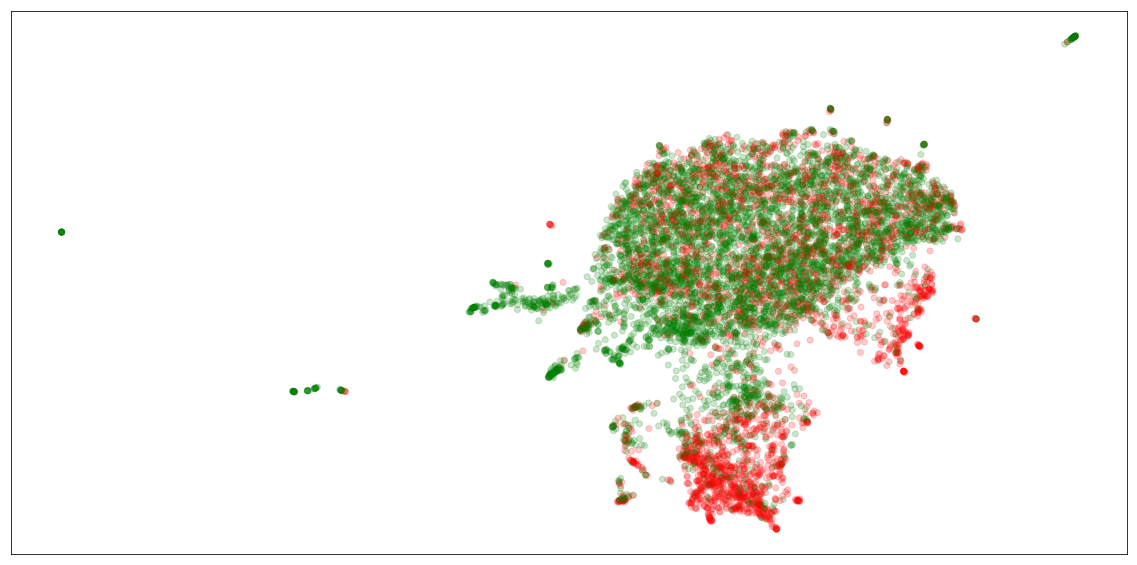

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20,10
plt.scatter(X_embedded.T[0], X_embedded.T[1], c=color_array, alpha=0.2)
# plt.title("Clustering accuracy={}, fmeasure_synth={}, number_of_labels={}".format(clustering_acc, fmeasure, 
#                                                                                   len(unique_labels)))
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
right='off', left='off', labelleft='off')
# plt.text(-5, 10, 'FastText', fontsize=24)
plt.savefig('../results/embedding_fasttext.png')
plt.show()

In [12]:
def get_all_subgraphs(mat_data, cl_ind):
    filtered_sub = mat_data[cl_ind,:][:]
    bigrams_count = np.count_nonzero(filtered_sub, axis=0)
#     print ("Bigrams count matrix shape : {}".format(bigrams_count.shape))
    zero_count_index = np.where(bigrams_count==0)[1]
#     print (zero_count_index)
    one_count_index = list(np.where(bigrams_count==1)[1])
#     print ("One count index : {}".format(one_count_index))
#     print ("Max zero count index : {} ".format(max(zero_count_index)))
    core_bigrams_index = list(np.where(bigrams_count>1)[1])
#     print ("Core Bigrams index : {}".format(len(core_bigrams_index)))
    outer_bigrams_index = list(one_count_index + core_bigrams_index)
    
    bigram_induced_graph = mat_data[:][:,core_bigrams_index]
#     print ("Bigram Induced Graph shape : {}".format(bigram_induced_graph.shape))
    ads_count = np.count_nonzero(bigram_induced_graph, axis=1)
    ads_in_shell_index = np.where(ads_count>1)[0]
    
    not_core_ads = list(set(list(ads_in_shell_index)) - set(cl_ind))
    not_core_bigrams = list(set(list(one_count_index)) - set(core_bigrams_index))
    mat_copy = np.asarray(mat_data)
    for i in not_core_ads:
        for j in not_core_bigrams:
            mat_copy[i][j] = 0
    shell_subgraph = mat_copy[ads_in_shell_index,:][:,outer_bigrams_index]
    mat_copy[not_core_ads, :] = 0
    outer_subgraph = mat_copy[ads_in_shell_index,:][:,outer_bigrams_index]
    mat_copy[:,one_count_index] = 0
    core_subgraph = mat_copy[ads_in_shell_index,:][:,outer_bigrams_index]
#     print ("Shell Subgraph shape : {}". format(shell_subgraph.shape))
#     print ("Outer Subgraph shape : {}". format(outer_subgraph.shape))
#     print ("Core Subgraph shape : {}". format(core_subgraph.shape))
#     print (zero_count_index.shape)
#     print (zero_count_index[1])
#     outer_subgraph = np.delete(filtered_sub, zero_count_index, axis=1)
#     core_subgraph = outer_subgraph.copy()
#     core_subgraph[:,one_count_index] = 0
#     core_subgraph = np.delete(filtered_sub, list(set(list(zero_count_index) + list(one_count_index))), axis=1)
    shell_subgraph = np.asarray(shell_subgraph)
    outer_subgraph = np.asarray(outer_subgraph)
    core_subgraph = np.asarray(core_subgraph)
#     print ("subgraph sizes: {}, {}, {}".format(core_subgraph.shape, outer_subgraph.shape, shell_subgraph.shape))
    
    return shell_subgraph, outer_subgraph, core_subgraph

In [13]:
bigram_matrix = bigram_matrix.todense()

In [14]:
import math

def calculate_unweighted_density(core_mat):
    edge_weight = np.count_nonzero(core_mat)
    ads_count = np.count_nonzero(core_mat, axis=0)
    bigrams_count = np.count_nonzero(core_mat, axis=1)
    ads_core_num = len(np.where(ads_count>0)[0])
    bigrams_core_num = len(np.where(bigrams_count>0)[0])
#     print (ads_core_num)
#     print (bigrams_core_num)
    return edge_weight/(ads_core_num * bigrams_core_num + 1)

def calculate_weighted_density(core_mat):
    edge_weight = np.sum(core_mat)
    ads_count = np.count_nonzero(core_mat, axis=0)
    bigrams_count = np.count_nonzero(core_mat, axis=1)
    ads_core_num = len(np.where(ads_count>0)[0])
    bigrams_core_num = len(np.where(bigrams_count>0)[0])

    return edge_weight/(ads_core_num * bigrams_core_num + 1)

def calculate_unweighted_fraudar_score(core_mat):
    edge_weight = np.count_nonzero(core_mat)
    ads_count = np.count_nonzero(core_mat, axis=0)
    bigrams_count = np.count_nonzero(core_mat, axis=1)
    ads_core_num = len(np.where(ads_count>0)[0])
    bigrams_core_num = len(np.where(bigrams_count>0)[0])
    
    return edge_weight/(ads_core_num + bigrams_core_num + 1)

def calculate_weighted_fraudar_score(core_mat):
    edge_weight = np.sum(core_mat)
    ads_count = np.count_nonzero(core_mat, axis=0)
    bigrams_count = np.count_nonzero(core_mat, axis=1)
    ads_core_num = len(np.where(ads_count>0)[0])
    bigrams_core_num = len(np.where(bigrams_count>0)[0])
    
    return edge_weight/(ads_core_num + bigrams_core_num + 1)

def calculate_unweighted_edge_per_score(core_mat, outer_mat):
    core_edges = np.count_nonzero(core_mat)
    outer_edges = np.count_nonzero(outer_mat)
    bigrams_count = np.count_nonzero(core_mat, axis=1)
    bigrams_core_num = len(np.where(bigrams_count>0)[0])
    
    return ((core_edges + 1)/(outer_edges +1))*(math.log(bigrams_core_num+1))

def calculate_weighted_edge_per_score(core_mat, outer_mat):
    core_edges = np.sum(core_mat)
    outer_edges = np.sum(outer_mat)
    
    bigrams_count = np.count_nonzero(core_mat, axis=1)
    bigrams_core_num = len(np.where(bigrams_count>0)[0])
    
    return ((core_edges + 1)/(outer_edges +1))*(math.log(bigrams_core_num+1))


def calculate_custom_score(core_mat, outer_mat):
    bigram_degrees = np.count_nonzero(np.asarray(core_mat), axis=0)
    bigrams_count = np.count_nonzero(core_mat, axis=1)
    bigrams_core_num = len(np.where(bigrams_count>0)[0])
    outer_edges = np.count_nonzero(outer_mat)
    bigram_degrees = bigram_degrees/bigrams_core_num
    
    ads_count = np.count_nonzero(core_mat, axis=0)
    ads_core_num = len(np.where(ads_count>0)[0])
    
    return (np.sum(bigram_degrees)/(outer_edges+1))*(math.log(bigrams_core_num+1))*(math.log(ads_core_num+1))
# #     print (mat.shape)
#     edges_nonzero = np.count_nonzero(mat, axis=0)
#     unique, counts = np.unique(edges_nonzero, return_counts=True)
#     degree_counts = dict(zip(unique, counts))
#     numerator = 0.0
#     denominator = 0.0
#     half = max(mat.shape[0]/2, 2)
#     for k, v in degree_counts.items():
#         if k == 0:
#             continue
#         elif k <= half:
#             denominator += k*v
#         else:
#             denominator += k*v
#             numerator += k*v
#     if denominator == 0.0:
#         return 0.0
#     else:
#         return numerator/denominator

# def calculate_weighted_edge_per_score(mat):
#     return 0.0

#Should be shell_mat instead of outer_mat, change once you figure out how to get shell subgraph.
def calculate_unweighted_modularity_score(core_mat, outer_mat, total_edges):
#     total_edges = math.log(total_edges)
    ad_degrees = np.count_nonzero(np.asarray(outer_mat), axis=1)
#     print (ad_degrees)
    bigram_degrees = np.count_nonzero(np.asarray(outer_mat), axis=0)
#     print (bigram_degrees)
    ads_count = np.count_nonzero(core_mat, axis=1)
    bigrams_count = np.count_nonzero(core_mat, axis=0)
    ads_core_index = np.where(ads_count>0)[0]
    bigrams_core_index = np.where(bigrams_count>0)[0]
#     ads_list_index = [x for x in range(core_mat.shape[0])]
#     nonzero_edges = np.transpose(np.nonzero(core_mat))
    summation = 0.0
    for i in ads_core_index:
        for j in bigrams_core_index:
            if core_mat[i][j] == 0:
                adj = 0
            else:
                adj = 1
            if adj == 1:
                summation += (adj - (ad_degrees[i] * bigram_degrees[j])/total_edges)

#     nonzero_edges = np.transpose(np.nonzero(core_mat))
#     summation = 0.0
#     for k in range(nonzero_edges.shape[0]):
#         ad_index = nonzero_edges[k][0]
#         big_index = nonzero_edges[k][1]
# #         print (ad_index)
# #         print (big_index)
# #         if core_mat[ad_index][big_index] != 0:
# #             adj = 1
# #         else:
# #             adj = 0
        
#         summation += (1 - (ad_degrees[ad_index] * bigram_degrees[big_index])/(2*total_edges))
    
    return (summation/total_edges)*(math.log(len(ads_core_index)+1))

def calculate_weighted_modularity_score(core_mat, outer_mat, total_edges):
    ad_degrees = np.sum(np.asarray(outer_mat), axis=1)
    bigram_degrees = np.sum(np.asarray(outer_mat), axis=0)
    
    ads_count = np.count_nonzero(core_mat, axis=1)
    bigrams_count = np.count_nonzero(core_mat, axis=0)
    ads_core_index = np.where(ads_count>0)[0]
    bigrams_core_index = np.where(bigrams_count>0)[0]

    

#     ads_list_index = [x for x in range(core_mat.shape[0])]
#     nonzero_edges = np.transpose(np.nonzero(core_mat))
    summation = 0.0
    for i in ads_core_index:
        for j in bigrams_core_index:
            if core_mat[i][j] != 0:
                summation += (core_mat[i][j] - (ad_degrees[i] * bigram_degrees[j])/total_edges)
#     summation = 0.0
#     for k in range(nonzero_edges.shape[0]):
#         ad_index = nonzero_edges[k][0]
#         big_index = nonzero_edges[k][1]
#         summation += (outer_mat[ad_index][big_index] - (ad_degrees[ad_index] * bigram_degrees[big_index])/(2*total_edges))
    
    return (summation/total_edges)*(math.log(len(ads_core_index)+1))

def calculate_pairwise_modularity(mat):
    mat = np.asarray(mat.todense())
    sim_scores = np.zeros((mat.shape[0], mat.shape[0]))
    for i in range(mat.shape[0]):
        for j in range(i+1, mat.shape[0]):
#             print ("i : {}, j : {}".format(i,j))
            if i == j:
                continue
#             print (len(mat[i]))
            sim_scores[i][j] = calculate_modularity_score(np.vstack((mat[i], mat[j])))
    
    return sim_scores

In [15]:
import gc
from sklearn.metrics.pairwise import cosine_similarity

def get_all_metrics(bigram_matrix, unique_labels, labels, df_data):
    eigen_ratios = []
    weighted_cluster_density = []
    unweighted_cluster_density = []
    unweighted_fraudar_scores = []
    weighted_fraudar_scores = []
    unweighted_outer_edge_perc_scores = []
    weighted_outer_edge_perc_scores = []
    unweighted_shell_edge_perc_scores = []
    weighted_shell_edge_perc_scores = []
    weighted_outer_modularity_scores = []
    unweighted_outer_modularity_scores = []
    weighted_shell_modularity_scores = []
    unweighted_shell_modularity_scores = []
    pairwise_similarity = []
    custom_score = []
    avg_label_scores = []
    max_label_scores = []
    sum_label_scores = []
    avg_binary_scores = []
    max_binary_scores = []
    sum_binary_scores = []
    clusters = []
    cluster_counts = []
    
    total_edges_unweighted = np.count_nonzero(bigram_matrix)
    total_edges_weighted = np.sum(bigram_matrix)
    for l in unique_labels:
#         s = bigram_matrix.sum(axis=1)
        if l== -1:
            weighted_cluster_density.append(0)
            unweighted_cluster_density.append(0)
            weighted_fraudar_scores.append(0)
            unweighted_fraudar_scores.append(0)
            weighted_outer_edge_perc_scores.append(0)
            unweighted_outer_edge_perc_scores.append(0)
            weighted_shell_edge_perc_scores.append(0)
            unweighted_shell_edge_perc_scores.append(0)
            unweighted_outer_modularity_scores.append(0)
            weighted_outer_modularity_scores.append(0)
            unweighted_shell_modularity_scores.append(0)
            weighted_shell_modularity_scores.append(0)
            pairwise_similarity.append(0)
            custom_score.append(0)
            cluster_counts.append(len(cluster_idx))
            eigen_ratios.append(0)
            clusters.append(l)
            
            max_label_scores.append(0)
            avg_label_scores.append(0)
            sum_label_scores.append(0)

            max_binary_scores.append(0)
            avg_binary_scores.append(0)
            sum_binary_scores.append(0)
            continue
#         print (s.shape)
#         print ("bigram matrix sum : {}".format(bigram_matrix.sum()))
#         print ("Zero elems: {}".format(len(np.argwhere(s==0))))
        cluster_idx = np.argwhere(labels == l).reshape(-1)
#         print (l, len(cluster_idx))
        
        print (cluster_idx)
        shell_subgraph, outer_subgraph, core_subgraph = get_all_subgraphs(bigram_matrix.copy(), cluster_idx)
#         print (l, len(cluster_idx), core_subgraph.sum(), outer_subgraph.sum(), shell_subgraph.sum())
        

        df_filt = df_data[df_data['cluster_label']== l]
        if len(df_filt) == 0 or core_subgraph.shape[0] == 0 or shell_subgraph.shape[0] == 0 or outer_subgraph.shape[0] == 0:
            weighted_cluster_density.append(0)
            unweighted_cluster_density.append(0)
            weighted_fraudar_scores.append(0)
            unweighted_fraudar_scores.append(0)
            weighted_outer_edge_perc_scores.append(0)
            unweighted_outer_edge_perc_scores.append(0)
            weighted_shell_edge_perc_scores.append(0)
            unweighted_shell_edge_perc_scores.append(0)
            unweighted_outer_modularity_scores.append(0)
            weighted_outer_modularity_scores.append(0)
            unweighted_shell_modularity_scores.append(0)
            weighted_shell_modularity_scores.append(0)
            pairwise_similarity.append(0)
            custom_score.append(0)
            cluster_counts.append(len(cluster_idx))
            eigen_ratios.append(0)
            clusters.append(l)
            
            max_label_scores.append(0)
            avg_label_scores.append(0)
            sum_label_scores.append(0)

            max_binary_scores.append(0)
            avg_binary_scores.append(0)
            sum_binary_scores.append(0)
            continue
#         elif core_subgraph.shape[0] == 0 or shell_subgraph.shape[0] == 0 or outer_subgraph.shape[0] == 0:
#             continue
        print (l, df_filt.shape)
        max_label_scores.append(max(df_filt['label']))
        avg_label_scores.append(sum(df_filt['label'])/len(df_filt['label']))
        sum_label_scores.append(sum(df_filt['label']))

        max_binary_scores.append(max(df_filt['binary_label']))
        avg_binary_scores.append(sum(df_filt['binary_label'])/len(df_filt['binary_label']))
        sum_binary_scores.append(sum(df_filt['binary_label']))
        
        local_content = list(df_filt['content_p'])
        count_vectorizer = TfidfVectorizer(ngram_range=(2,2), use_idf=False)
        count_data = count_vectorizer.fit_transform(local_content)

        svd = TruncatedSVD(n_components=2)
        local_vecs = svd.fit_transform(count_data)
        w = svd.singular_values_
        if len(w) > 1:
            eigen_rat = w[1]/w[0]
        else:
            eigen_rat = 1
        eigen_ratios.append(eigen_rat)
        
        print (outer_subgraph.shape)
        print (core_subgraph.shape)
        pairwise_sim_mat = cosine_similarity(outer_subgraph, dense_output=True)
        pairwise_sim_mat = np.tril(pairwise_sim_mat, -1)
#         print (sum(pairwise_sim_mat).shape)
        print (pairwise_sim_mat.sum())
        an_score = calculate_weighted_edge_per_score(core_subgraph, outer_subgraph)
        names = [x.lower() if type(x) == type('') else None for x in df_filt['Name'].unique()]
        if math.nan in names:
            names.remove(math.nan)
        if None in names:
            names.remove(None)
        names = list(set(names))
        c_score = an_score * max(0, len(names)-1)
        print ("Scores : {}, {}, {}".format(an_score, len(names), c_score))
        weighted_cluster_density.append(calculate_weighted_density(core_subgraph))
        unweighted_cluster_density.append(calculate_unweighted_density(core_subgraph))
        weighted_fraudar_scores.append(calculate_weighted_fraudar_score(core_subgraph))
        unweighted_fraudar_scores.append(calculate_unweighted_fraudar_score(core_subgraph))
        weighted_outer_edge_perc_scores.append(calculate_weighted_edge_per_score(core_subgraph, outer_subgraph))
        unweighted_outer_edge_perc_scores.append(calculate_unweighted_edge_per_score(core_subgraph, outer_subgraph))
        weighted_shell_edge_perc_scores.append(calculate_weighted_edge_per_score(core_subgraph, shell_subgraph))
        unweighted_shell_edge_perc_scores.append(calculate_unweighted_edge_per_score(core_subgraph, shell_subgraph))
        unweighted_outer_modularity_scores.append(calculate_unweighted_modularity_score(core_subgraph, outer_subgraph, total_edges_unweighted))
        weighted_outer_modularity_scores.append(calculate_weighted_modularity_score(core_subgraph, outer_subgraph, total_edges_weighted))
        unweighted_shell_modularity_scores.append(calculate_unweighted_modularity_score(core_subgraph, shell_subgraph, total_edges_unweighted))
        weighted_shell_modularity_scores.append(calculate_weighted_modularity_score(core_subgraph, shell_subgraph, total_edges_weighted))
        custom_score.append(c_score)
        pairwise_similarity.append(pairwise_sim_mat.sum()/len(cluster_idx))
        cluster_counts.append(len(cluster_idx)) 
        clusters.append(l)
        
        count_data = []
        local_content = []
        shell_subgraph = []
        core_subgraph = []
        outer_subgraph = []
        if l % 50 == 0:
            print (l)
            gc.collect()
#     original_labels = labels.copy()

    metrics = {}
    metrics['weighted_cluster_density'] = weighted_cluster_density
    metrics['unweighted_cluster_density'] = unweighted_cluster_density
    metrics['weighted_fraudar_scores'] = weighted_fraudar_scores
    metrics['unweighted_fraudar_scores'] = unweighted_fraudar_scores
    metrics['weighted_outer_edge_perc_scores'] = weighted_outer_edge_perc_scores
    metrics['unweighted_outer_edge_perc_scores'] = unweighted_outer_edge_perc_scores
    metrics['weighted_shell_edge_perc_scores'] = weighted_shell_edge_perc_scores
    metrics['unweighted_shell_edge_perc_scores'] = unweighted_shell_edge_perc_scores
    metrics['unweighted_outer_modularity_scores'] = unweighted_outer_modularity_scores
    metrics['weighted_outer_modularity_scores'] = weighted_outer_modularity_scores
    metrics['unweighted_shell_modularity_scores'] = unweighted_shell_modularity_scores
    metrics['weighted_shell_modularity_scores'] = weighted_shell_modularity_scores
    metrics['pairwise_similarity'] = pairwise_similarity
    metrics['custom_score'] = custom_score
    metrics['avg_label_scores'] = avg_label_scores
    metrics['sum_label_scores'] = sum_label_scores
    metrics['max_label_scores'] = max_label_scores
    metrics['avg_binary_scores'] = avg_binary_scores
    metrics['max_binary_scores'] = max_binary_scores
    metrics['sum_binary_scores'] = sum_binary_scores
    metrics['eigen_ratios'] = eigen_ratios
    metrics['clusters'] = clusters
    metrics['labels'] = labels.copy()
    metrics['cluster_counts'] = cluster_counts
    
    return metrics


In [16]:
pre_merging_metrics = get_all_metrics(bigram_matrix, unique_labels, labels, df_data)

[70 71 72]
0 (1, 19)
(4263, 152)
(4263, 152)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.7436919984316184
Scores : 1.013587401190619, 0, 0.0
0
[73 74 75 76]
1 (1, 19)
(3309, 94)
(3309, 94)
4.4205960254888765
Scores : 0.8470797706287787, 0, 0.0
[288 290 314 315 316 317]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2 (1, 19)
(1330, 52)
(1330, 52)
13.454537016242458
Scores : 1.8526292843131253, 0, 0.0
[62 63 64 65 67]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3 (1, 19)
(3383, 77)
(3383, 77)
9.77287512724901
Scores : 1.751655606343965, 1, 0.0
[56 57 58 68 69]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


4 (1, 19)
(5740, 135)
(5740, 135)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


8.417883948082078
Scores : 1.705848871770293, 1, 0.0
[2907 3531 4037 7257]
5 (1, 19)
(2927, 68)
(2927, 68)
5.80315199624559
Scores : 1.5662249921229807, 1, 0.0
[46 47 48 49]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


6 (2, 19)
(6617, 113)
(6617, 113)
5.978963495732083
Scores : 1.5946125509081528, 0, 0.0
[78 79 80 81 82 83]
7 (7, 19)
(4854, 95)
(4854, 95)
14.487541830213523
Scores : 1.8999541865174963, 0, 0.0
[   6    7    8    9   10   11   12   13   14 6828 8431 8516 8952]
8 (1, 19)
(1167, 32)
(1167, 32)
75.19261504106902
Scores : 2.5544460198951255, 1, 0.0
[84 87 88 89]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


9 (1, 19)
(5982, 103)
(5982, 103)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


5.819569176669528
Scores : 1.5785789526833183, 1, 0.0
[85 90 91]
10 (1, 19)
(5992, 105)
(5992, 105)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.8946240930372773
Scores : 1.3535215708931092, 1, 0.0
[1215 1225 1243]
11 (2, 19)
(5563, 36)
(5563, 36)
2.5688666624441447
Scores : 1.23779316888996, 1, 0.0
[ 599 5312 7928]
12 (1, 19)
(3983, 49)
(3983, 49)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.0003237710881554
Scores : 1.0136265058986957, 1, 0.0
[3894 8080 8388]
13 (1, 19)
(1580, 11)
(1580, 11)
3.0
Scores : 1.3862943611198906, 0, 0.0
[2276 2280 2282]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


14 (1, 19)
(4387, 54)
(4387, 54)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.729252748516747
Scores : 1.3617925570126819, 0, 0.0
[1518 1576 7072 7178 7340 8981]
15 (1, 19)
(6633, 100)
(6633, 100)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


6.945894964410872
Scores : 1.5412181647644756, 1, 0.0
[ 545  547  549 3018 6744]
16 (1, 19)
(6544, 73)
(6544, 73)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


6.898223780368783
Scores : 1.616938959593933, 1, 0.0
[244 246 247 250 253]
17 (1, 19)
(2751, 41)
(2751, 41)
8.95605477536295
Scores : 1.7409820589780767, 0, 0.0
[4444 5600 8545 8707]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


18 (3, 19)
(4480, 58)
(4480, 58)
4.58022379749775
Scores : 1.39553927597192, 0, 0.0
[4929 5142 7878]
19 (1, 19)
(5731, 66)
(5731, 66)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.3558266929325595
Scores : 1.0257725192735303, 0, 0.0
[3223 3700 4644]
20 (2, 19)
(4266, 31)
(4266, 31)
3.000000000000001
Scores : 1.3862943611198906, 2, 1.3862943611198906
[4070 5605 5737]
21 (5, 19)
(5909, 60)
(5909, 60)
2.0699057539343233
Scores : 1.0992691652551243, 1, 0.0
[ 745  746  747 2997 4302]
22 (1, 19)
(3375, 44)
(3375, 44)
8.646851989046517
Scores : 1.7615095875536608, 0, 0.0
[ 775 1849 6460]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


23 (1, 19)
(5571, 69)
(5571, 69)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.8768119441852655
Scores : 1.0978413957303659, 0, 0.0
[5143 5640 7211]
24 (1, 19)
(13, 42)
(13, 42)
1.125766957821537
Scores : 0.6220916569990359, 0, 0.0
[ 814 2905 8298]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


25 (1, 19)
(3654, 45)
(3654, 45)
2.528894559517682
Scores : 1.3505602295822194, 0, 0.0
[6526 7314 7323]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


26 (1, 19)
(2980, 26)
(2980, 26)
2.74455335698641
Scores : 1.3706850342830401, 1, 0.0
[1555 1557 3046 7363]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


27 (1, 19)
(3817, 51)
(3817, 51)
3.88775000689871
Scores : 1.4161949200636608, 1, 0.0


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


[1663 1668 3744]
28 (2, 19)
(2137, 59)
(2137, 59)
1.8475742023606818
Scores : 1.0675982840001546, 0, 0.0
[ 190 3247 6341]
29 (1, 19)
(5756, 50)
(5756, 50)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.610537663070505
Scores : 1.3800181321846867, 0, 0.0
[3465 4094 6210]
30 (4, 19)
(6446, 50)
(6446, 50)
2.9999999999999996
Scores : 1.3862943611198906, 2, 1.3862943611198906
[3235 3578 3797]
31 (1, 19)
(3044, 43)
(3044, 43)
2.8798231963321905
Scores : 1.3383052340951083, 0, 0.0
[4660 4815 6580]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


32 (1, 19)
(4295, 37)
(4295, 37)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.000000000000001
Scores : 1.3862943611198906, 1, 0.0
[6183 6218 6378]
33 (2, 19)
(4703, 75)
(4703, 75)
0.9343785661848028
Scores : 0.5780216907659221, 1, 0.0
[3252 3286 3379]
34 (2, 19)
(3930, 40)
(3930, 40)
3.000000000000001
Scores : 1.3862943611198906, 1, 0.0
[ 977  978  980  981  982  983 4768 5439 8692]
35 (1, 19)
(6872, 99)
(6872, 99)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


20.964835817702358
Scores : 2.0523535555983803, 1, 0.0
[165 166 167]
36 (2, 19)
(4838, 38)
(4838, 38)
2.815074931764634
Scores : 1.3510397753452557, 1, 0.0
[ 771  772 3768 4228 8177]
37 (2, 19)
(6340, 80)
(6340, 80)
4.648365524938971
Scores : 1.4338451380885375, 1, 0.0
[3325 5189 5785 8748]
38 (1, 19)
(6213, 61)
(6213, 61)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


4.160560860085096
Scores : 1.3334546330245107, 1, 0.0
[ 400 3287 8264]
39 (6, 19)
(6183, 47)
(6183, 47)
2.67152807424286
Scores : 1.2865414418433798, 3, 2.5730828836867596
[ 243  245  248  249  251  252 8091]
40 (2, 19)
(3995, 63)
(3995, 63)
17.252568829252787
Scores : 1.877291213448912, 1, 0.0
[4079 5826 8710]
41 (1, 19)
(6935, 52)
(6935, 52)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.7516434723473098
Scores : 1.3359105064936856, 0, 0.0
[1409 2382 4364]
42 (2, 19)
(1381, 36)
(1381, 36)
1.7539889406112548
Scores : 0.6786069481893978, 0, 0.0
[1921 1922 8297]
43 (4, 19)
(4870, 29)
(4870, 29)
2.722586405452436
Scores : 1.3862943611198906, 2, 1.3862943611198906
[5061 5092 6258]
44 (1, 19)
(5323, 51)
(5323, 51)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.528548154481621
Scores : 1.292640796024518, 1, 0.0
[3486 4119 7227 7466]
45 (6, 19)
(6793, 63)
(6793, 63)
4.0073226082183435
Scores : 1.383867398583307, 2, 1.383867398583307
[3164 3964 4864 6683 7172]
46 (7, 19)
(6250, 48)
(6250, 48)
6.986459351399302
Scores : 1.6735113488040412, 3, 3.3470226976080824
[ 616  617 4832 8112]
47 (4, 19)
(5547, 30)
(5547, 30)
4.150318972071699
Scores : 1.394998545734507, 3, 2.789997091469014
[3880 6675 8571]
48 (1, 19)
(1900, 66)
(1900, 66)
1.3731709171760176
Scores : 1.0314886123304576, 0, 0.0
[3623 5177 7534]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


49 (1, 19)
(4319, 48)
(4319, 48)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.6193744661823155
Scores : 1.027552732665652, 0, 0.0
[1664 1779 1973 3481 8946]
50 (1, 19)
(4344, 59)
(4344, 59)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


7.308568045107712
Scores : 1.6937162443639184, 1, 0.0
50
[  32   33   34   35   36  158 6040]
51 (1, 19)
(3555, 81)
(3555, 81)
12.902938940542999
Scores : 1.8911018230693741, 0, 0.0
[2660 6001 6343]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


52 (1, 19)
(3487, 32)
(3487, 32)
2.5065576865092596
Scores : 1.2283160982416115, 0, 0.0
[1612 1614 7914]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


53 (4, 19)
(3979, 48)
(3979, 48)
1.3221658613273624
Scores : 1.012890098012037, 4, 3.0386702940361108
[2595 4296 7134 7184 7573 8440]
54 (2, 19)
(1411, 111)
(1411, 111)
1.4041333274440477
Scores : 0.6283669121445662, 2, 0.6283669121445662
[3060 3326 6377]
55 (1, 19)
(3978, 25)
(3978, 25)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.0
Scores : 1.3862943611198906, 0, 0.0
[3850 5546 6506]
56 (1, 19)
(6366, 50)
(6366, 50)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.143782540028885
Scores : 1.1898623043862393, 0, 0.0
[1164 5929 6835]
57 (2, 19)
(5456, 51)
(5456, 51)
1.4188550057011282
Scores : 0.9820195817003703, 0, 0.0
[4322 6158 7247]
58 (1, 19)
(2120, 41)
(2120, 41)
3.000000000000001
Scores : 1.3862943611198906, 0, 0.0
[3614 5302 6815]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


59 (1, 19)
(6374, 80)
(6374, 80)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.868133975072073
Scores : 1.363649873339833, 0, 0.0
[3501 4664 6847]
60 (2, 19)
(1241, 57)
(1241, 57)
1.3412664048946648
Scores : 0.6284570787171447, 1, 0.0
[1296 1297 5461 5655]
61 (1, 19)
(6532, 48)
(6532, 48)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


5.42812170363472
Scores : 1.5353386714462116, 0, 0.0
[3382 4963 8129]
62 (1, 19)
(4108, 69)
(4108, 69)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.576425070551147
Scores : 0.8152060657470879, 0, 0.0
[4205 4284 7922]
63 (1, 19)
(5415, 40)
(5415, 40)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.000000000000001
Scores : 1.3862943611198906, 0, 0.0
[269 270 272]
64 (1, 19)
(202, 35)
(202, 35)
2.2349918443095937
Scores : 1.0339231610581794, 1, 0.0
[3012 5997 7741]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


65 (1, 19)
(6152, 37)
(6152, 37)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.9455359009443445
Scores : 1.36833170158357, 0, 0.0
[3676 3824 6851]
66 (3, 19)
(4931, 50)
(4931, 50)
2.1236967935150854
Scores : 1.0514595964025504, 1, 0.0
[ 436  437 5153]
67 (3, 19)
(2502, 37)
(2502, 37)
2.723623858610889
Scores : 1.3060135644984314, 0, 0.0
[3136 5692 6170]
68 (1, 19)
(4931, 41)
(4931, 41)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.8585525855717187
Scores : 1.3557544286600571, 0, 0.0
[ 296 1224 7177 7593]
69 (1, 19)
(6793, 90)
(6793, 90)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.3963423243328927
Scores : 1.0423864428725282, 0, 0.0
[2133 4026 6047 7731]
70 (1, 19)
(5900, 67)
(5900, 67)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.0584312205045916
Scores : 1.5792666668754993, 0, 0.0
[3370 6216 6710]
71 (1, 19)
(5417, 78)
(5417, 78)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.0000000000000013
Scores : 1.3862943611198906, 0, 0.0
[15 17 18 19 20 23 24]
72 (1, 19)
(6607, 101)
(6607, 101)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


20.163430476251516
Scores : 2.027997421727535, 1, 0.0
[ 241  242 5547 5627]
73 (2, 19)
(2756, 21)
(2756, 21)
5.0832127433626635
Scores : 1.5247501004161856, 0, 0.0
[2003 2095 2096]
74 (5, 19)
(3228, 31)
(3228, 31)
2.836919506757618
Scores : 1.3588516751174673, 2, 1.3588516751174673
[ 188  189 5783 7754]
75 (1, 19)
(5397, 44)
(5397, 44)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


5.661684174018749
Scores : 1.6037008346163841, 0, 0.0
[ 710  711  712  713 4564 6895]
76 (1, 19)
(7358, 66)
(7358, 66)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


11.81536015470854
Scores : 1.7210801786351058, 0, 0.0
[2779 3491 8008 8937]
77 (1, 19)
(3108, 45)
(3108, 45)
4.260815410520696
Scores : 1.3523683809448237, 0, 0.0
[5629 7316 8156]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


78 (1, 19)
(3753, 69)
(3753, 69)
1.650031168993947
Scores : 0.8784130481456777, 0, 0.0


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


[2568 4343 5306 6707]
79 (1, 19)
(343, 22)
(343, 22)
0.33122703037712026
Scores : 0.4274929118294819, 0, 0.0
[1183 2058 3836]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


80 (4, 19)
(5012, 61)
(5012, 61)
1.2343370098564548
Scores : 0.8216005948366435, 1, 0.0
[3138 4430 7110]
81 (1, 19)
(5869, 45)
(5869, 45)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.4371284548987013
Scores : 1.3348049524156425, 1, 0.0
[6379 7129 8322]
82 (2, 19)
(4649, 44)
(4649, 44)
2.063244615127826
Scores : 1.0631645549108573, 0, 0.0
[1604 2784 3902 5140]
83 (3, 19)
(4267, 39)
(4267, 39)
4.53476628990181
Scores : 1.6094379124341003, 0, 0.0
[2963 3321 4808 6599 6915 6960]
84 (2, 19)
(6151, 56)
(6151, 56)
10.733600599732227
Scores : 1.861009321275791, 1, 0.0
[1866 1867 1868 1870]
85 (1, 19)
(1601, 34)
(1601, 34)
5.389379343777166
Scores : 1.569734203264148, 0, 0.0
[1811 1869 1872]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


86 (1, 19)
(4978, 38)
(4978, 38)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.17877960746662
Scores : 1.2944419755017809, 0, 0.0
[1105 1106 3496 8286]
87 (1, 19)
(3966, 28)
(3966, 28)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.8970308315005346
Scores : 1.257243607319434, 1, 0.0
[1639 2915 6026]
88 (1, 19)
(4881, 45)
(4881, 45)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.3631005332655017
Scores : 0.9817284299442476, 1, 0.0
[3649 4101 4476 4759 5541 6072]
89 (1, 19)
(6808, 100)
(6808, 100)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


5.337492272567379
Scores : 1.404575566299783, 0, 0.0
[6626 7119 7493 8161]
90 (3, 19)
(5880, 63)
(5880, 63)
3.896567413754134
Scores : 1.3121403276543737, 1, 0.0
[1536 3025 5791]
91 (2, 19)
(5069, 38)
(5069, 38)
2.9862816278857407
Scores : 1.3862943611198906, 1, 0.0
[1807 3416 4185]
92 (1, 19)
(2224, 66)
(2224, 66)
1.0722433022582696
Scores : 0.5880922675134762, 0, 0.0
[2132 2732 3884 5260 7258]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


93 (3, 19)
(4322, 82)
(4322, 82)
4.892609361238015
Scores : 1.4681983528266285, 0, 0.0
[ 424 5157 7389 8790]
94 (2, 19)
(5706, 31)
(5706, 31)
5.629428129489337
Scores : 1.5596922670519482, 0, 0.0
[ 859 3083 7890]
95 (1, 19)
(5960, 52)
(5960, 52)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.8452379628768394
Scores : 1.062259389394632, 0, 0.0
[1334 1394 1423]
96 (4, 19)
(5798, 33)
(5798, 33)
2.438109263697129
Scores : 1.2206313215123326, 2, 1.2206313215123326
[4156 6356 6532]
97 (2, 19)
(6162, 52)
(6162, 52)
1.4635817696488256
Scores : 0.9476924752310096, 1, 0.0
[ 541  542  544 8557 8956]
98 (1, 19)
(6091, 42)
(6091, 42)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


7.441745222290074
Scores : 1.5404835536495285, 0, 0.0
[ 648  676 6535]
99 (1, 19)
(3813, 52)
(3813, 52)
1.8250686199536734
Scores : 1.049549003599421, 0, 0.0


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


[378 384 390]
100 (2, 19)
(5232, 61)
(5232, 61)
2.045018602767483
Scores : 1.0866517862720997, 0, 0.0
100
[2453 2454 6952]
101 (3, 19)
(4502, 62)
(4502, 62)
1.8315327893749527
Scores : 1.1418354928695997, 1, 0.0
[ 329 2182 2187]
102 (1, 19)
(4342, 61)
(4342, 61)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.400435924632104
Scores : 1.0508204797421035, 0, 0.0
[4226 7563 8496]
103 (1, 19)
(5214, 34)
(5214, 34)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.441981629797937
Scores : 1.2622763636466348, 1, 0.0
[6321 6424 7960]
104 (2, 19)
(6806, 38)
(6806, 38)
3.0
Scores : 1.3862943611198906, 0, 0.0
[1339 1907 6941 8843]
105 (1, 19)
(3883, 54)
(3883, 54)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.2226127576347015
Scores : 1.0587205781679416, 0, 0.0
[2716 3363 8219]
106 (1, 19)
(4723, 52)
(4723, 52)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.8643371149571772
Scores : 1.0981998780522986, 0, 0.0
[ 811 2739 2870 3289 4899 6708 7421]
107 (1, 19)
(7654, 100)
(7654, 100)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


8.26071577491074
Scores : 1.5811372150381018, 0, 0.0
[ 810  812 5850]
108 (4, 19)
(5895, 55)
(5895, 55)
1.951901158708906
Scores : 1.1911207709286007, 2, 1.1911207709286007
[ 491 4098 5836]
109 (1, 19)
(4699, 75)
(4699, 75)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


0.9106741727721214
Scores : 0.7250958408800493, 0, 0.0
[ 484  498 6495]
110 (6, 19)
(6848, 51)
(6848, 51)
2.0105372345170225
Scores : 1.1276859856944652, 0, 0.0
[1707 3487 7794]
111 (11, 19)
(3619, 46)
(3619, 46)
2.2770968321776976
Scores : 1.232310471916023, 3, 2.464620943832046
[4278 5729 8406]
112 (4, 19)
(4793, 69)
(4793, 69)
1.2207101030681256
Scores : 1.0025629076235882, 2, 1.0025629076235882
[122 123 124 202 203 204 205 206 207 208 209 210 212]
113 (1, 19)
(6932, 96)
(6932, 96)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


56.764770476566255
Scores : 2.424576442881494, 0, 0.0
[281 282 283 284 285 286]
114 (1, 19)
(3523, 31)
(3523, 31)
12.602971110351668
Scores : 1.8936361694841854, 0, 0.0
[1592 4307 5121]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


115 (1, 19)
(2825, 88)
(2825, 88)
0.4333296163950763
Scores : 0.43708848079021245, 0, 0.0
[4340 6146 6504 6931]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


116 (1, 19)
(3132, 49)
(3132, 49)
1.1228485602643516
Scores : 0.5440313982043008, 0, 0.0
[7045 7146 8668]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


117 (4, 19)
(6294, 42)
(6294, 42)
2.433627374605704
Scores : 1.2677984497764037, 4, 3.803395349329211
[ 788 6814 7225 7694]
118 (2, 19)
(4050, 106)
(4050, 106)
1.193557438302657
Scores : 0.6865862827543986, 0, 0.0
[4435 6175 7088]
119 (1, 19)
(6065, 42)
(6065, 42)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.000000000000001
Scores : 1.3862943611198906, 0, 0.0
[3648 6951 8800]
120 (5, 19)
(5331, 41)
(5331, 41)
2.981873811456059
Scores : 1.3862943611198906, 0, 0.0
[4643 4812 6930]
121 (2, 19)
(4005, 65)
(4005, 65)
1.3190714487272808
Scores : 0.9220216792085761, 0, 0.0
[4223 5086 7803]
122 (1, 19)
(4945, 57)
(4945, 57)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.6388887216800798
Scores : 0.9503695626417873, 0, 0.0
[1735 3434 4034 4743 6042 7753]
123 (1, 19)
(6495, 52)
(6495, 52)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


11.44457433154256
Scores : 1.749468367843666, 1, 0.0
[228 229 230 231 232]
124 (4, 19)
(1555, 43)
(1555, 43)
9.344122878074277
Scores : 1.755377285915418, 4, 5.266131857746254
[3453 4893 5573]
125 (1, 19)
(5100, 39)
(5100, 39)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


3.0
Scores : 1.3862943611198906, 0, 0.0
[3870 5594 7602]
126 (1, 19)
(4846, 38)
(4846, 38)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


2.4464470734960324
Scores : 1.3137416563214122, 0, 0.0
[ 510  658 5473 5970]
127 (4, 19)
(5187, 59)
(5187, 59)
3.2946066101032523
Scores : 1.176301797079036, 0, 0.0
[3281 3347 4030 5488 5649 6108 6253 7933 8549]
128 (7, 19)
(6661, 98)
(6661, 98)
19.62911906324754
Scores : 1.7793358300130109, 0, 0.0
[1459 3178 4403]
129 (4, 19)
(4941, 76)
(4941, 76)
0.31271357163686775
Scores : 0.40232554453033675, 1, 0.0
[ 942 1632 4221 4654 4919 8423 8525 8560]
130 (9, 19)
(6518, 120)
(6518, 120)
7.817057410673874
Scores : 1.4505581380522232, 9, 11.604465104417786
[ 291  292  293 7892]
131 (1, 19)
(5862, 49)
(5862, 49)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


4.457901021655449
Scores : 1.3695009434162964, 0, 0.0
[1533 1534 1535 6589]
132 (1, 19)
(2917, 52)
(2917, 52)
5.125625824996549
Scores : 1.4184505500325668, 0, 0.0
[2524 2590 5742]
133 (4, 19)
(23, 65)
(23, 65)
0.8874081256598563
Scores : 0.435724224252852, 0, 0.0
[1258 1466 5717]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


134 (4, 19)
(6314, 55)
(6314, 55)
2.071243079259878
Scores : 1.2004632727346143, 3, 2.4009265454692286
[1166 4755 5256 5533 8474]
135 (4, 19)
(5275, 43)
(5275, 43)
7.751131393712543
Scores : 1.6256627352336408, 3, 3.2513254704672816
[2291 2380 5527]
136 (3, 19)
(2276, 62)
(2276, 62)
1.0606301003838055
Scores : 0.7151106536901167, 3, 1.4302213073802335
[4269 5736 5758]
137 (3, 19)
(6432, 52)
(6432, 52)
1.190582979187538
Scores : 1.0620382011520038, 3, 2.1240764023040075
[ 847 1570 1781 4104 7863]
138 (4, 19)
(4950, 109)
(4950, 109)
1.6960602310642536
Scores : 0.7820704053627533, 0, 0.0
[3794 7344 8586]
139 (3, 19)
(6147, 49)
(6147, 49)
2.2474193350730567
Scores : 1.1597369808415705, 3, 2.319473961683141
[1504 1505 3033 3738]
140 (3, 19)
(7108, 61)
(7108, 61)
4.573158298121577
Scores : 1.4378069476269772, 1, 0.0
[2883 3624 5296]
141 (1, 19)
(2514, 90)
(2514, 90)
1.6030183137880971
Scores : 0.9030771542950038, 0, 0.0
[3807 4033 7686]


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


142 (3, 19)
(5207, 57)
(5207, 57)
1.6235401211519527
Scores : 0.9625963591954911, 0, 0.0
[1589 1675 1677]
143 (2, 19)
(5078, 69)
(5078, 69)
1.7162720529093156
Scores : 1.1080069950525167, 0, 0.0
[1185 1190 4690 6135]
144 (7, 19)
(5925, 49)
(5925, 49)
4.230391871665196
Scores : 1.3638251407998991, 2, 1.3638251407998991
[ 418  419  420  423 4266 5136]
145 (1, 19)
(5648, 81)
(5648, 81)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


6.962401243806708
Scores : 1.4919436284442684, 0, 0.0
[1026 1027 1028 8410]
146 (2, 19)
(6957, 43)
(6957, 43)
5.279021084531831
Scores : 1.5049310009903631, 0, 0.0
[2703 5866 6304 6592 7206 7373 7374]
147 (1, 19)
(7356, 80)
(7356, 80)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


10.649986339016019
Scores : 1.6772719305881276, 1, 0.0
[1679 1680 1681 1683 8025]
148 (4, 19)
(4381, 60)
(4381, 60)
6.230736062851475
Scores : 1.5267639562379247, 2, 1.5267639562379247
[3204 4613 5935]
149 (3, 19)
(4987, 38)
(4987, 38)
2.5126511444924846
Scores : 1.282353466122266, 2, 1.282353466122266
[1401 3987 6244]
150 (15, 19)
(5614, 42)
(5614, 42)
1.796269353845374
Scores : 1.1865569559135445, 13, 14.238683470962535
150
[1452 3375 6407 8193]
151 (8, 19)
(4205, 55)
(4205, 55)
4.77667405657613
Scores : 1.4243400408050984, 5, 5.697360163220393
[3592 4121 4594 6510 6619 7127]
152 (6, 19)
(6615, 112)
(6615, 112)
3.667262298554775
Scores : 1.2874781165198366, 4, 3.8624343495595097
[357 362 367]
153 (6, 19)
(5655, 63)
(5655, 63)
1.46411709505738
Scores : 0.8812233383851764, 2, 0.8812233383851764
[2877 2912 3749 4222 6497 7261]
154 (18, 19)
(5867, 38)
(5867, 38)
10.996194189103488
Scores : 1.8137337656332286, 12, 19.951071421965516
[259 262 263 264 265 266]
155 (4, 19)
(5073, 22)
(5073, 

/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


5.528165367936001
Scores : 1.5968211847386165, 0, 0.0
[4212 4566 7973]
173 (6, 19)
(2959, 48)
(2959, 48)
3.0000000000000013
Scores : 1.3862943611198906, 3, 2.772588722239781
[3854 3921 6315 7004 8968 8976]
174 (3, 19)
(6414, 82)
(6414, 82)
5.236886649187057
Scores : 1.267008884266484, 3, 2.534017768532968
[1129 1130 2909]
175 (7, 19)
(6531, 48)
(6531, 48)
1.9668914506813997
Scores : 1.1690606448235126, 4, 3.5071819344705375
[1426 1909 2238 5544 7659 7869]
176 (5, 19)
(6742, 65)
(6742, 65)
5.429320303052826
Scores : 1.470319149000449, 5, 5.881276596001796
[ 454 1876 8361]
177 (4, 19)
(950, 78)
(950, 78)
0.2641334699853176
Scores : 0.35475174150828587, 4, 1.0642552245248575
[1315 2976 4501]
178 (4, 19)
(2754, 77)
(2754, 77)
0.32907019167271034
Scores : 0.38173538491287123, 3, 0.7634707698257425
[25 26 27 28]
179 (8, 19)
(3831, 42)
(3831, 42)
5.826998196165888
Scores : 1.595461058626299, 4, 4.786383175878897
[3331 5297 6323 8321 8625]
180 (10, 19)
(2339, 45)
(2339, 45)
6.243780896509145
S

/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


[2175 2680 3126 3189 4904 5679 7281]
205 (5, 19)
(7905, 142)
(7905, 142)
3.1630863552368456
Scores : 1.2101259447333546, 2, 1.2101259447333546
[ 608  609  610  612 5589]
206 (4, 19)
(1314, 38)
(1314, 38)
5.9227820841729315
Scores : 1.4577083611287334, 3, 2.9154167222574667
[5955 8024 8832]
207 (4, 19)
(3019, 31)
(3019, 31)
2.4375848429114493
Scores : 1.288006409009981, 3, 2.576012818019962
[ 991  992  993  994 6630 7713]
208 (10, 19)
(4962, 78)
(4962, 78)
7.504082514065942
Scores : 1.473303161780126, 6, 7.36651580890063
[6655 7176 8059]
209 (3, 19)
(6120, 37)
(6120, 37)
2.5232883641692267
Scores : 1.2631381712733587, 2, 1.2631381712733587
[ 480 3500 5727]
210 (13, 19)
(3275, 62)
(3275, 62)
0.9348852132978529
Scores : 0.7628777388550884, 7, 4.57726643313053
[3271 3980 6749 8262]
211 (9, 19)
(5034, 45)
(5034, 45)
2.998727421895218
Scores : 1.1487544801310252, 4, 3.446263440393076
[ 997  999 7450]
212 (6, 19)
(6472, 38)
(6472, 38)
2.677636811309127
Scores : 1.2515463999469127, 3, 2.503092

/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/decomposition/truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


1.5884752691284303
Scores : 1.1363196582818937, 1, 0.0
[2395 6727 7902]
239 (2, 19)
(1489, 21)
(1489, 21)
2.6600282260274177
Scores : 1.333486890333057, 1, 0.0
[1829 2049 2183 2184]
240 (4, 19)
(5531, 50)
(5531, 50)
3.492894520045894
Scores : 1.2102142894982844, 4, 3.630642868494853
[3172 4512 5150]
241 (3, 19)
(4495, 62)
(4495, 62)
0.503052197865943
Scores : 0.7057219412849635, 3, 1.411443882569927
[2867 3042 3249 3489 3569 4143 4746 4914 5870 6993 7141 7342 7348 7883]
242 (7, 19)
(7750, 145)
(7750, 145)
36.450629991915086
Scores : 2.098405169819191, 6, 10.492025849095954
[3765 4129 7017 7219]
243 (3, 19)
(4506, 49)
(4506, 49)
4.6138987194504
Scores : 1.4582053408776945, 2, 1.4582053408776945
[2475 2517 5882]
244 (5, 19)
(4887, 58)
(4887, 58)
1.1916321579550866
Scores : 1.0420619091909835, 4, 3.1261857275729508
[ 153 5133 5454 5951]
245 (3, 19)
(2318, 15)
(2318, 15)
5.534481159213287
Scores : 1.5713420320107834, 3, 3.1426840640215667
[4753 5595 8818]
246 (9, 19)
(5524, 45)
(5524, 45)


In [17]:
suspicious_scores = pre_merging_metrics['custom_score']
text_similarity = pre_merging_metrics['pairwise_similarity']
clusters = pre_merging_metrics['clusters']
avg_label_scores = pre_merging_metrics['avg_label_scores']
avg_binary_scores = pre_merging_metrics['avg_binary_scores']
w_density = pre_merging_metrics['weighted_cluster_density']
uw_density = pre_merging_metrics['unweighted_cluster_density']
w_fraudar = pre_merging_metrics['weighted_fraudar_scores']
uw_fraudar = pre_merging_metrics['unweighted_fraudar_scores']
w_outer_edge = pre_merging_metrics['weighted_outer_edge_perc_scores']
uw_outer_edge = pre_merging_metrics['unweighted_outer_edge_perc_scores']
w_shell_edge = pre_merging_metrics['weighted_shell_edge_perc_scores']
uw_shell_edge = pre_merging_metrics['unweighted_shell_edge_perc_scores']
w_outer_mod = pre_merging_metrics['weighted_outer_modularity_scores']
uw_outer_mod = pre_merging_metrics['unweighted_outer_modularity_scores']
w_shell_mod = pre_merging_metrics['weighted_shell_modularity_scores']
uw_shell_mod = pre_merging_metrics['unweighted_shell_modularity_scores']

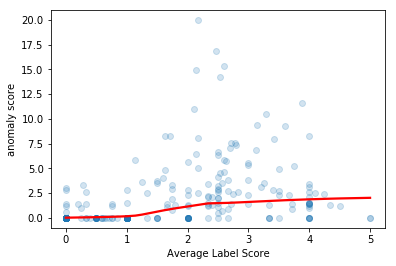

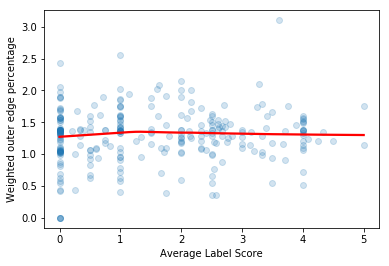

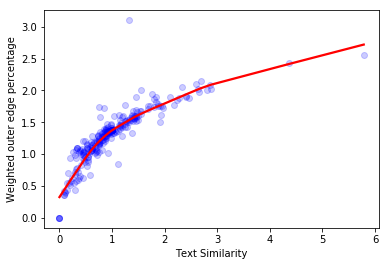

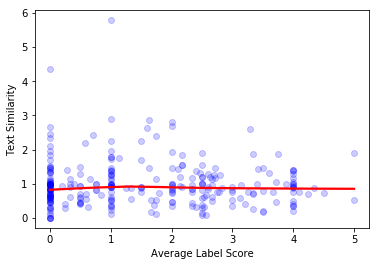

In [18]:
import seaborn as sns


ax = sns.regplot(x=avg_label_scores, y=suspicious_scores, x_ci=68, truncate=False, lowess=True, scatter_kws = {'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Average Label Score', ylabel='anomaly score')
plt.show()

ax = sns.regplot(x=avg_label_scores, y=w_outer_edge, x_ci=68, truncate=False, lowess=True, scatter_kws = {'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Average Label Score', ylabel='Weighted outer edge percentage')
plt.show()

# import seaborn as sns
ax = sns.regplot(x=text_similarity, y=w_outer_edge, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Text Similarity', ylabel='Weighted outer edge percentage')
plt.show()


ax = sns.regplot(x=avg_label_scores, y=text_similarity, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Average Label Score', ylabel='Text Similarity')
plt.show()
# import seaborn as sns
# ax = sns.regplot(x=avg_label_scores, y=w_outer_edge, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
# ax.set(xlabel='Average Label Score', ylabel='Weighted outer edge percentage')
# plt.show()

# import seaborn as sns
# ax = sns.regplot(x=avg_label_scores, y=w_outer_edge, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
# ax.set(xlabel='Average Label Score', ylabel='Weighted outer edge percentage')
# plt.show()

# import seaborn as sns
# ax = sns.regplot(x=avg_label_scores, y=w_outer_edge, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
# ax.set(xlabel='Average Label Score', ylabel='Weighted outer edge percentage')
# plt.show()

# import seaborn as sns
# ax = sns.regplot(x=avg_label_scores, y=w_outer_edge, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
# ax.set(xlabel='Average Label Score', ylabel='Weighted outer edge percentage')
# plt.show()


# plt.scatter(avg_label_scores, w_outer_edge, alpha=0.2)
# plt.title('Avg label score vs weighted outer edge percentage')
# plt.xlabel('avg label score')
# plt.ylabel('weighted outer edge percentage')
# # w = np.linalg.lstsq(avg_label_scores, w_outer_edge)[0]
# # yh = np.dot(avg_label_scores,w)
# # plt.plot(avg_label_scores, yh, 'r-')
# plt.show()

# plt.scatter(avg_label_scores, w_shell_edge, alpha=0.2)
# plt.title('Avg label score vs weighted shell edge percentage')
# plt.xlabel('avg label score')
# plt.ylabel('weighted shell edge percentage')
# plt.show()

# plt.scatter(text_similarity, w_outer_edge, alpha=0.2)
# plt.title('Avg text similarity vs weighted outer edge percentage')
# plt.xlabel('avg text similarity')
# plt.ylabel('weighted outer edge percentage')

# # plt.scatter(avg_label_scores, w_shell_edge, alpha=0.2)
# # plt.title('Avg label score vs weighted shell edge percentage')
# # plt.xlabel('avg label score')
# # plt.ylabel('weighted shell edge percentage')
# plt.show()

In [19]:
def filter_by_name(clusters, df_data):
    filtered_clusters = []
    for cl in clusters:
        df_fil = df_data[df_data['cluster_label']==cl]
        names = [x.lower() if type(x) == type('') else None for x in df_fil['Name'].unique()]
        if math.nan in names:
            names.remove(math.nan)
        if None in names:
            names.remove(None)
        names = list(set(names))
        if len(names)>1:
#             print (names)
            filtered_clusters.append(cl)
#             filtered_cluster_metric.append(anomaly_cluster_metric[ind])
#         else:
#             filtered_clusters.append(c)
#             filtered_cluster_metric.append(anomaly_cluster_metric[ind])
    return filtered_clusters

def filter_by_threshold(clusters, metric, threshold=0.0):
    filtered_clusters = []
    index_list = [i for i, e in enumerate(metric) if e > threshold]
    filtered_clusters = [clusters[i] for i in index_list] 
    
    return filtered_clusters

In [20]:
filtered_clusters = filter_by_name(clusters, df_data.copy())
print (filtered_clusters)
filtered_clusters = set(filtered_clusters)
index_list = [i for i, e in enumerate(clusters) if e in filtered_clusters]
filtered_avg_label_scores = [avg_label_scores[i] for i in index_list] 
filtered_text_similarity = [text_similarity[i] for i in index_list] 
filtered_suspicious_scores = [suspicious_scores[i] for i in index_list] 
filtered_avg_binary_scores = [avg_binary_scores[i] for i in index_list] 
filtered_w_density = [w_density[i] for i in index_list] 
filtered_uw_density = [uw_density[i] for i in index_list] 
filtered_w_fraudar = [w_fraudar[i] for i in index_list] 
filtered_uw_fraudar = [uw_fraudar[i] for i in index_list] 
filtered_w_outer_edge = [w_outer_edge[i] for i in index_list] 
filtered_uw_outer_edge = [uw_outer_edge[i] for i in index_list] 
filtered_w_shell_edge = [w_shell_edge[i] for i in index_list] 
filtered_uw_shell_edge = [uw_shell_edge[i] for i in index_list] 
filtered_w_outer_mod = [w_outer_mod[i] for i in index_list] 
filtered_uw_outer_mod = [uw_outer_mod[i] for i in index_list] 
filtered_w_shell_mod = [w_shell_mod[i] for i in index_list] 
filtered_uw_shell_mod = [uw_shell_mod[i] for i in index_list] 

[20, 30, 39, 43, 45, 46, 47, 53, 54, 74, 96, 108, 111, 112, 117, 124, 130, 134, 135, 136, 137, 139, 144, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 198, 199, 200, 201, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 253, 254, 255, 256, 257, 259, 262, 263, 265, 266, 267, 268, 269, 270, 271, -1]


==================================k = 10========================================


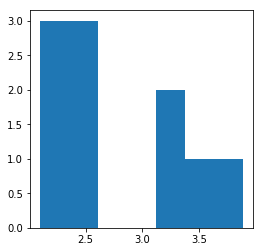

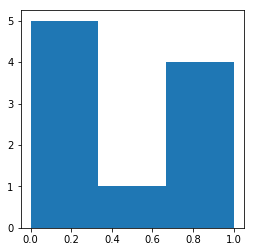

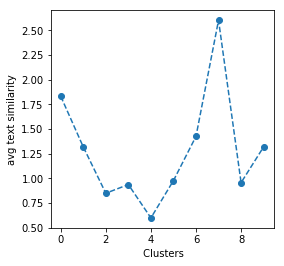

Average of average label scores : 2.7920490620490623
Average text similarity : 1.281898243177907


Spearman Correlation | Average Label Score |          Text Similarity          | 0.01 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | -0.77 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | -0.79 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | -0.13 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.10 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | 0.16 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.25 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | 0.16 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.25 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | 0.60 
Spearman Correlation | Aver

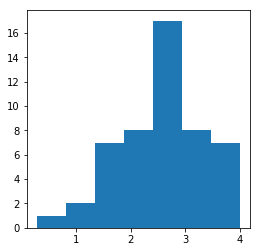

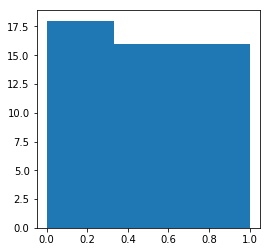

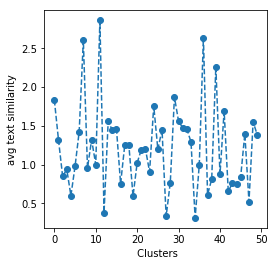

Average of average label scores : 2.5473904428904426
Average text similarity : 1.217923730913631


Spearman Correlation | Average Label Score |          Text Similarity          | -0.25 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | -0.04 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | -0.18 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.32 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | -0.17 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.16 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | -0.17 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.16 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.17 
Spearman Correlation | A

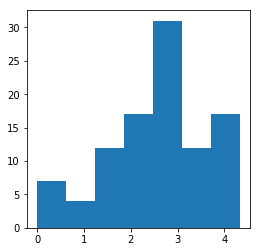

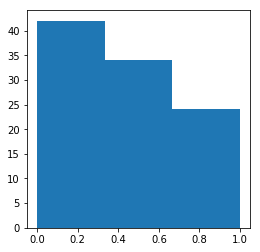

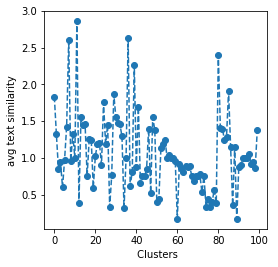

Average of average label scores : 2.5307233599733605
Average text similarity : 1.055854701792027


Spearman Correlation | Average Label Score |          Text Similarity          | -0.19 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.07 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | -0.03 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | -0.16 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.26 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | -0.13 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.01 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | -0.13 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.01 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.15 
Spearman Correlation | A

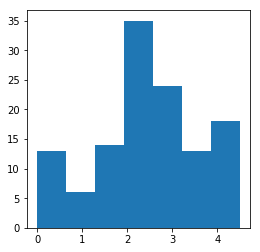

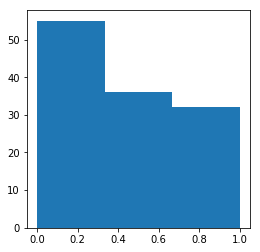

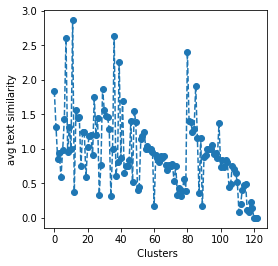

Average of average label scores : 1.9849425574425577
Average text similarity : 0.7691638027267937


Spearman Correlation | Average Label Score |          Text Similarity          | -0.02 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.19 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | 0.06 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | 0.01 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.09 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.04 
Spearman Correlation | Aver

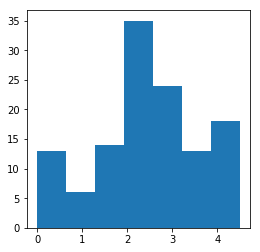

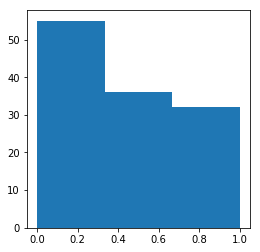

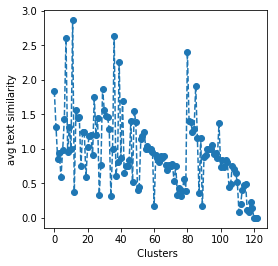

Average of average label scores : 1.4887069180819181
Average text similarity : 0.5768728520450953


Spearman Correlation | Average Label Score |          Text Similarity          | -0.02 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.19 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | 0.06 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | 0.01 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.09 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.04 
Spearman Correlation | Aver

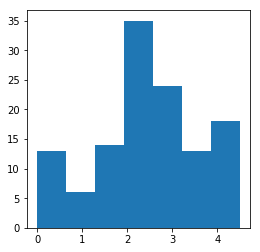

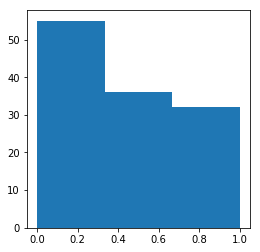

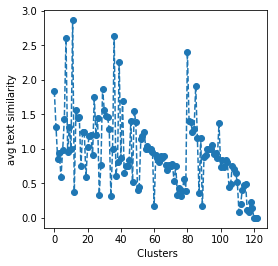

Average of average label scores : 1.1909655344655345
Average text similarity : 0.4614982816360762


Spearman Correlation | Average Label Score |          Text Similarity          | -0.02 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.19 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | 0.06 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | 0.01 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.09 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.04 
Spearman Correlation | Aver

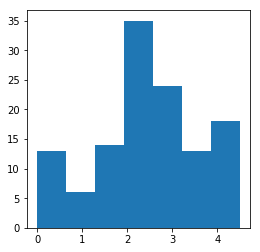

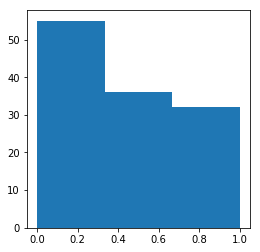

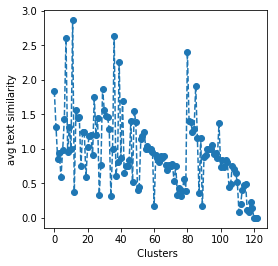

Average of average label scores : 0.9924712787212788
Average text similarity : 0.38458190136339687


Spearman Correlation | Average Label Score |          Text Similarity          | -0.02 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.19 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | 0.06 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | 0.01 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.09 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.04 
Spearman Correlation | Ave

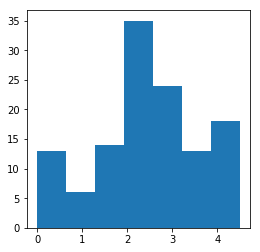

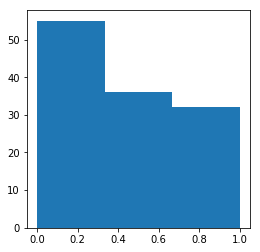

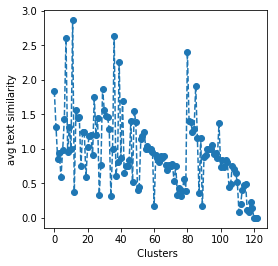

Average of average label scores : 0.8506896674753819
Average text similarity : 0.32964162974005445


Spearman Correlation | Average Label Score |          Text Similarity          | -0.02 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.19 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | 0.06 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | 0.01 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.09 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.04 
Spearman Correlation | Ave

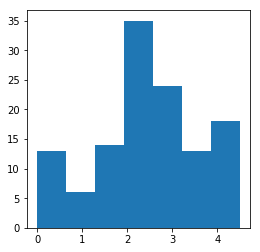

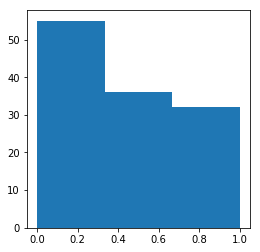

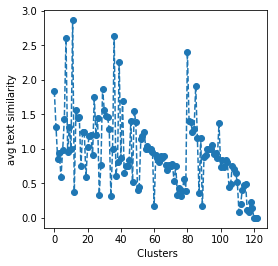

Average of average label scores : 0.7443534590409591
Average text similarity : 0.28843642602254765


Spearman Correlation | Average Label Score |          Text Similarity          | -0.02 
Spearman Correlation | Average Label Score |     Weighted Cluster Density      | 0.19 
Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | 0.06 
Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | 0.01 
Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | -0.09 
Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | 0.02 
Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | 0.07 
Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | -0.04 
Spearman Correlation | Ave

In [21]:
from scipy.stats import spearmanr
import plotly.express as px

filtered_suspicious_scores, filtered_clusters, filtered_avg_label_scores, filtered_text_similarity, \
filtered_w_density, filtered_uw_density, filtered_w_fraudar,  filtered_uw_fraudar, filtered_w_outer_edge, \
filtered_uw_outer_edge, filtered_w_shell_edge, filtered_uw_shell_edge,  filtered_w_outer_mod, \
filtered_uw_outer_mod, filtered_w_shell_mod, filtered_uw_shell_mod = \
zip(*sorted(zip(filtered_suspicious_scores, filtered_clusters, filtered_avg_label_scores, filtered_text_similarity, 
                filtered_w_density, filtered_uw_density, filtered_w_fraudar,  filtered_uw_fraudar, 
                filtered_w_outer_edge, filtered_uw_outer_edge, filtered_w_shell_edge, filtered_uw_shell_edge,  
                filtered_w_outer_mod, filtered_uw_outer_mod, filtered_w_shell_mod, filtered_uw_shell_mod)))
filtered_suspicious_scores = list(reversed(filtered_suspicious_scores))
filtered_clusters = list(reversed(filtered_clusters))
filtered_avg_label_scores = list(reversed(filtered_avg_label_scores))
filtered_text_similarity = list(reversed(filtered_text_similarity))
filtered_avg_binary_scores = list(reversed(filtered_avg_binary_scores))
filtered_w_density = list(reversed(filtered_w_density))
filtered_uw_density = list(reversed(filtered_uw_density))
filtered_w_fraudar = list(reversed(filtered_w_fraudar))  
filtered_uw_fraudar = list(reversed(filtered_uw_fraudar))
filtered_w_outer_edge = list(reversed(filtered_w_outer_edge)) 
filtered_uw_outer_edge = list(reversed(filtered_w_density)) 
filtered_w_shell_edge = list(reversed(filtered_w_shell_edge))
filtered_uw_shell_edge = list(reversed(filtered_uw_shell_edge))  
filtered_w_outer_mod = list(reversed(filtered_w_outer_mod)) 
filtered_uw_outer_mod = list(reversed(filtered_uw_outer_mod)) 
filtered_w_shell_mod = list(reversed(filtered_w_shell_mod)) 
filtered_uw_shell_mod = list(reversed(filtered_uw_shell_mod))
top_k = [10, 50, 100, 150, 200, 250, 300, 350, 400]
rcParams['figure.figsize'] = 4,4
for k in top_k:
    print ('==================================k = {}========================================'.format(k) )
    plt.hist(filtered_avg_label_scores[:k], bins=7)
    plt.show()
    
    plt.hist(filtered_avg_binary_scores[:k], bins=3)
    plt.show()
    
    plt.plot(filtered_text_similarity[:k], marker='o', linestyle='--')
    plt.xlabel(' Clusters')
    plt.ylabel('avg text similarity')
    plt.show()
    
    print ("Average of average label scores : {}".format(sum(filtered_avg_label_scores[:k])/k))
    print ("Average text similarity : {}".format(sum(filtered_text_similarity[:k])/k))
    print ('\n')
    eig_ts_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_text_similarity[:k])[0]
    eig_w_den_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_w_density[:k])[0]
    eig_uw_den_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_uw_density[:k])[0]
    eig_w_fraud_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_w_fraudar[:k])[0]
    eig_uw_fraud_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_uw_fraudar[:k])[0]
    eig_w_edge_out_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_w_outer_edge[:k])[0]
    eig_uw_edge_out_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_uw_outer_edge[:k])[0]
    eig_w_edge_shell_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_w_shell_edge[:k])[0]
    eig_uw_edge_shell_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_uw_shell_edge[:k])[0]
    eig_w_mod_out_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_w_outer_mod[:k])[0]
    eig_uw_mod_out_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_uw_outer_mod[:k])[0]
    eig_w_mod_shell_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_w_shell_mod[:k])[0]
    eig_uw_mod_shell_pscore = spearmanr(filtered_avg_label_scores[:k], filtered_uw_shell_mod[:k])[0]
    
    print ("Spearman Correlation | Average Label Score |          Text Similarity          | {0:.2f} ".format(eig_ts_pscore))
    print ("Spearman Correlation | Average Label Score |     Weighted Cluster Density      | {0:.2f} ".format(eig_w_den_pscore))
    print ("Spearman Correlation | Average Label Score |    UnWeighted Cluster Density     | {0:.2f} ".format(eig_uw_den_pscore))
    print ("Spearman Correlation | Average Label Score |      Weighted Fraudar Score       | {0:.2f} ".format(eig_w_fraud_pscore))
    print ("Spearman Correlation | Average Label Score |     UnWeighted Fraudar Score      | {0:.2f} ".format(eig_uw_fraud_pscore))
    print ("Spearman Correlation | Average Label Score |     Weighted Outer Edge Perc      | {0:.2f} ".format(eig_w_edge_out_pscore))
    print ("Spearman Correlation | Average Label Score |    UnWeighted Outer Edge Perc     | {0:.2f} ".format(eig_uw_edge_out_pscore))
    print ("Spearman Correlation | Average Label Score |     Weighted Shell Edge Perc      | {0:.2f} ".format(eig_w_edge_out_pscore))
    print ("Spearman Correlation | Average Label Score |    UnWeighted Shell Edge Perc     | {0:.2f} ".format(eig_uw_edge_out_pscore))
    print ("Spearman Correlation | Average Label Score |  Weighted Outer Modularity Score  | {0:.2f} ".format(eig_w_mod_out_pscore))
    print ("Spearman Correlation | Average Label Score | UnWeighted Outer Modularity Score | {0:.2f} ".format(eig_uw_mod_out_pscore))
    print ("Spearman Correlation | Average Label Score |  Weighted Shell Modularity Score  | {0:.2f} ".format(eig_w_mod_shell_pscore))
    print ("Spearman Correlation | Average Label Score | UnWeighted Shell Modularity Score | {0:.2f} ".format(eig_uw_mod_shell_pscore))
    
    eig_w_den_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_w_density[:k])[0]
    eig_uw_den_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_uw_density[:k])[0]
    eig_w_fraud_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_w_fraudar[:k])[0]
    eig_uw_fraud_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_uw_fraudar[:k])[0]
    eig_w_edge_out_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_w_outer_edge[:k])[0]
    eig_uw_edge_out_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_uw_outer_edge[:k])[0]
    eig_w_edge_shell_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_w_shell_edge[:k])[0]
    eig_uw_edge_shell_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_uw_shell_edge[:k])[0]
    eig_w_mod_out_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_w_outer_mod[:k])[0]
    eig_uw_mod_out_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_uw_outer_mod[:k])[0]
    eig_w_mod_shell_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_w_shell_mod[:k])[0]
    eig_uw_mod_shell_pscore = spearmanr(filtered_avg_binary_scores[:k], filtered_uw_shell_mod[:k])[0]
    
    print ('\n')
    print ("Spearman Correlation | Average Binary Score |     Weighted Cluster Density      | {0:.2f} ".format(eig_w_den_pscore))
    print ("Spearman Correlation | Average Binary Score |    UnWeighted Cluster Density     | {0:.2f} ".format(eig_uw_den_pscore))
    print ("Spearman Correlation | Average Binary Score |      Weighted Fraudar Score       | {0:.2f} ".format(eig_w_fraud_pscore))
    print ("Spearman Correlation | Average Binary Score |     UnWeighted Fraudar Score      | {0:.2f} ".format(eig_uw_fraud_pscore))
    print ("Spearman Correlation | Average Binary Score |     Weighted Outer Edge Perc      | {0:.2f} ".format(eig_w_edge_out_pscore))
    print ("Spearman Correlation | Average Binary Score |    UnWeighted Outer Edge Perc     | {0:.2f} ".format(eig_uw_edge_out_pscore))
    print ("Spearman Correlation | Average Binary Score |     Weighted Shell Edge Perc      | {0:.2f} ".format(eig_w_edge_out_pscore))
    print ("Spearman Correlation | Average Binary Score |    UnWeighted Shell Edge Perc     | {0:.2f} ".format(eig_uw_edge_out_pscore))
    print ("Spearman Correlation | Average Binary Score |  Weighted Outer Modularity Score  | {0:.2f} ".format(eig_w_mod_out_pscore))
    print ("Spearman Correlation | Average Binary Score | UnWeighted Outer Modularity Score | {0:.2f} ".format(eig_uw_mod_out_pscore))
    print ("Spearman Correlation | Average Binary Score |  Weighted Shell Modularity Score  | {0:.2f} ".format(eig_w_mod_shell_pscore))
    print ("Spearman Correlation | Average Binary Score | UnWeighted Shell Modularity Score | {0:.2f} ".format(eig_uw_mod_shell_pscore))
print (len(clusters))

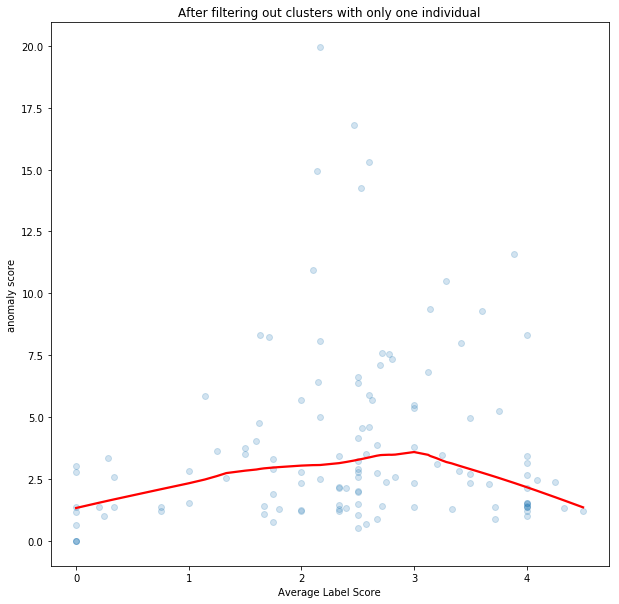

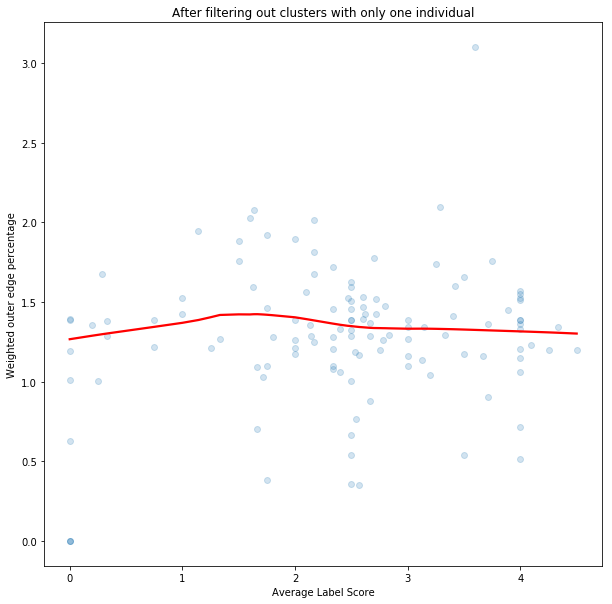

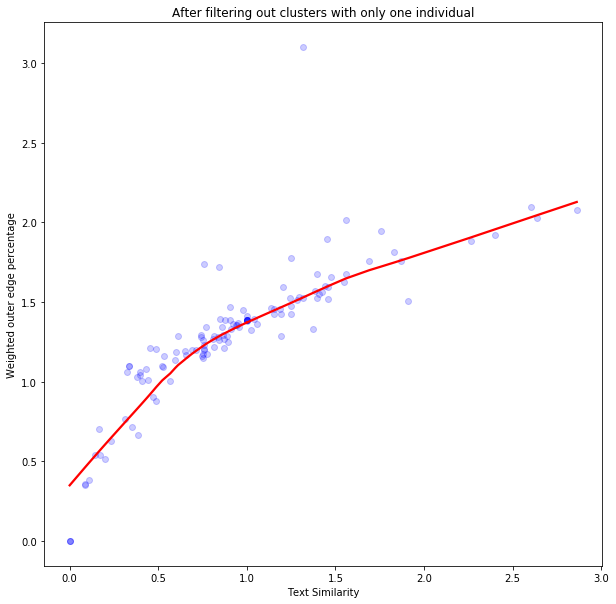

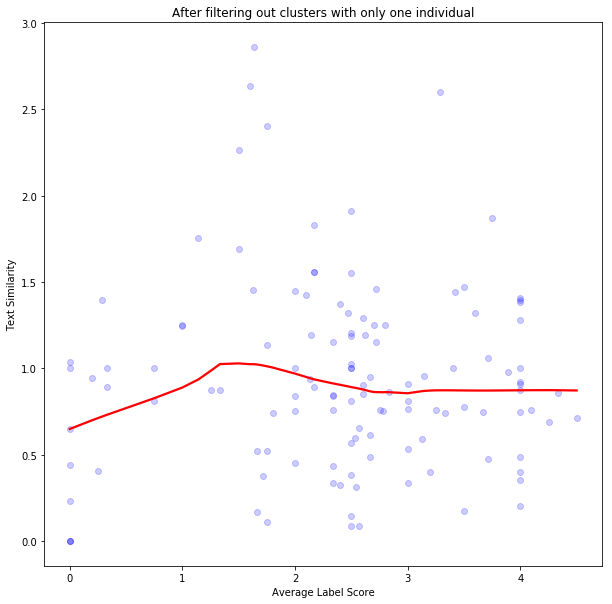

In [22]:
rcParams['figure.figsize'] = 10,10

ax = sns.regplot(x=filtered_avg_label_scores, y=filtered_suspicious_scores, x_ci=68, truncate=False, lowess=True, scatter_kws = {'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Average Label Score', ylabel='anomaly score')
plt.title('After filtering out clusters with only one individual')
plt.show()

ax = sns.regplot(x=filtered_avg_label_scores, y=filtered_w_outer_edge, x_ci=68, truncate=False, lowess=True, scatter_kws = {'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Average Label Score', ylabel='Weighted outer edge percentage')
plt.title('After filtering out clusters with only one individual')
plt.show()

# import seaborn as sns
ax = sns.regplot(x=filtered_text_similarity, y=filtered_w_outer_edge, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Text Similarity', ylabel='Weighted outer edge percentage')
plt.title('After filtering out clusters with only one individual')
plt.show()


ax = sns.regplot(x=filtered_avg_label_scores, y=filtered_text_similarity, ci=68, truncate=False, lowess=True, scatter_kws = {'color': 'b', 'alpha': 0.2}, line_kws = {'color': 'red'})
ax.set(xlabel='Average Label Score', ylabel='Text Similarity')
plt.title('After filtering out clusters with only one individual')
plt.show()

In [23]:
suspicious_scores = pre_merging_metrics['weighted_outer_edge_perc_scores']
text_similarity = pre_merging_metrics['pairwise_similarity']
clusters = pre_merging_metrics['clusters']
avg_label_scores = pre_merging_metrics['avg_label_scores']
avg_binary_scores = pre_merging_metrics['avg_binary_scores']
w_density = pre_merging_metrics['weighted_cluster_density']
uw_density = pre_merging_metrics['unweighted_cluster_density']
w_fraudar = pre_merging_metrics['weighted_fraudar_scores']
uw_fraudar = pre_merging_metrics['unweighted_fraudar_scores']
w_outer_edge = pre_merging_metrics['weighted_outer_edge_perc_scores']
uw_outer_edge = pre_merging_metrics['unweighted_outer_edge_perc_scores']
w_shell_edge = pre_merging_metrics['weighted_shell_edge_perc_scores']
uw_shell_edge = pre_merging_metrics['unweighted_shell_edge_perc_scores']
w_outer_mod = pre_merging_metrics['weighted_outer_modularity_scores']
uw_outer_mod = pre_merging_metrics['unweighted_outer_modularity_scores']
w_shell_mod = pre_merging_metrics['weighted_shell_modularity_scores']
uw_shell_mod = pre_merging_metrics['unweighted_shell_modularity_scores']
cluster_counts = pre_merging_metrics['cluster_counts']

In [24]:
suspicious_scores, clusters, avg_label_scores, text_similarity, \
w_density, uw_density, w_fraudar,  uw_fraudar, w_outer_edge, \
uw_outer_edge, w_shell_edge, uw_shell_edge,  w_outer_mod, \
uw_outer_mod, w_shell_mod, uw_shell_mod, cluster_counts = \
zip(*sorted(zip(suspicious_scores, clusters, avg_label_scores, text_similarity, 
                w_density, uw_density, w_fraudar,  uw_fraudar, w_outer_edge, 
                uw_outer_edge, w_shell_edge, uw_shell_edge,  w_outer_mod, 
                uw_outer_mod, w_shell_mod, uw_shell_mod, cluster_counts)))
suspicious_scores = list(reversed(suspicious_scores))
clusters = list(reversed(clusters))
avg_label_scores = list(reversed(avg_label_scores))
text_similarity = list(reversed(text_similarity))
# filtered_avg_binary_scores = list(reversed(filtered_avg_binary_scores))
w_density = list(reversed(w_density))
uw_density = list(reversed(uw_density))
w_fraudar = list(reversed(w_fraudar))  
uw_fraudar = list(reversed(uw_fraudar))
w_outer_edge = list(reversed(w_outer_edge)) 
uw_outer_edge = list(reversed(uw_outer_edge)) 
w_shell_edge = list(reversed(w_shell_edge))
uw_shell_edge = list(reversed(uw_shell_edge))  
w_outer_mod = list(reversed(w_outer_mod)) 
uw_outer_mod = list(reversed(uw_outer_mod)) 
w_shell_mod = list(reversed(w_shell_mod)) 
uw_shell_mod = list(reversed(uw_shell_mod))
cluster_counts = list(reversed(cluster_counts))

In [25]:
content = list(df_data['content_p'])
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(2, 3), norm='l2', 
    smooth_idf=True, stop_words=stop_words, min_df=2, max_df=0.8)
# where_are_nans = np.isnan(content)
# content[where_are_nans] = 0
bigram_matrix = vectorizer.fit_transform(content)

print (bigram_matrix.shape)

(8988, 66336)


In [26]:
df_data['cluster_label'] = labels

In [27]:
new_index = range(len(df_data))
df_data = df_data.reindex(new_index)
# print (df_da.index)

In [28]:
k=50
sort_ind = []
for ind, cl in enumerate(clusters[:k]):
    if cl==-1 or cl==-2:
        continue
    else:
        df_f = df_data[df_data['cluster_label'] == cl]
        print (df_f.shape)
#         if df_f.shape[0] < 20:
#             continue
        sort_ind += list(df_f.index)
print (sort_ind)

(109, 19)
(13, 19)
(13, 19)
(10, 19)
(14, 19)
(7, 19)
(9, 19)
(7, 19)
(9, 19)
(7, 19)
(9, 19)
(9, 19)
(7, 19)
(9, 19)
(6, 19)
(10, 19)
(6, 19)
(7, 19)
(6, 19)
(7, 19)
(6, 19)
(6, 19)
(6, 19)
(9, 19)
(9, 19)
(5, 19)
(5, 19)
(5, 19)
(6, 19)
(5, 19)
(6, 19)
(5, 19)
(17, 19)
(5, 19)
(6, 19)
(5, 19)
(5, 19)
(7, 19)
(5, 19)
(5, 19)
(5, 19)
(5, 19)
(6, 19)
(5, 19)
(4, 19)
(4, 19)
(4, 19)
(4, 19)
(4, 19)
(4, 19)
[503, 561, 759, 1880, 1891, 2155, 2330, 2336, 2378, 2438, 2487, 2490, 2535, 2536, 2548, 2550, 2555, 2560, 2569, 2574, 2577, 2578, 2580, 2582, 2584, 2586, 2588, 2589, 2592, 2597, 2598, 2600, 2602, 2603, 2606, 2607, 2609, 2612, 2613, 2614, 2616, 2618, 2621, 2622, 2623, 2626, 2630, 2631, 2632, 2634, 2636, 2638, 2639, 2640, 2647, 2648, 2700, 2746, 2798, 2896, 2975, 3156, 3316, 3380, 4130, 4166, 4474, 4490, 4513, 4695, 4780, 4937, 5004, 5128, 5285, 5302, 5375, 5396, 5505, 5582, 5710, 5874, 5910, 6077, 6144, 6188, 6190, 6441, 6510, 6882, 6883, 6904, 6971, 7168, 7253, 7271, 7314, 7383, 7439, 

(8988, 8988)


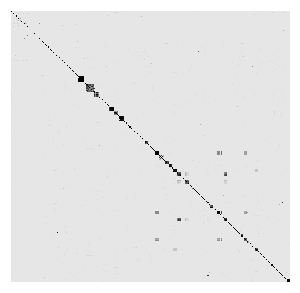

In [33]:

sim_matrix = cosine_similarity(bigram_matrix)
print (sim_matrix.shape)
# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(111)
# ax.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
# right='off', left='off', labelleft='off')
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
ax = sns.heatmap(sim_matrix[sort_ind, :][:,sort_ind], cmap=cmap, xticklabels=False, yticklabels=False, cbar=False)
# ax.set(xlabel='cosine similarity', ylabel='cosine_similarity')
plt.savefig('../results/sim_matrix.png')

In [30]:
noise_index = clusters.index(-1)
del suspicious_scores[noise_index]
del text_similarity[noise_index]
del clusters[noise_index]
del avg_label_scores[noise_index]
del avg_binary_scores[noise_index]
del w_density[noise_index]
del uw_density[noise_index]
del w_fraudar[noise_index]
del uw_fraudar[noise_index]
del w_outer_edge[noise_index]
del uw_outer_edge[noise_index]
del w_shell_edge[noise_index]
del uw_shell_edge[noise_index]
del w_outer_mod[noise_index]
del uw_outer_mod[noise_index]
del w_shell_mod[noise_index]
del uw_shell_mod[noise_index]
del cluster_counts[noise_index]

In [31]:
k = 50

In [32]:
total_ads_in_clusters = sum(cluster_counts)
avg_of_avg_label_scores = sum(avg_label_scores[:k])/k
avg_of_anomaly_scores = sum(suspicious_scores[:k])/k
avg_text_similarity = sum(text_similarity[:k])/k
avg_cluster_size = sum(cluster_counts[:k])/k

print ("Total ads in clusters: {}, Average of label scores per cluster: {}, \
average of anomaly scores per cluster: {}, Average text sim: {}, avg cluster size: {}".format(
total_ads_in_clusters, avg_of_avg_label_scores, avg_of_anomaly_scores, avg_text_similarity, avg_cluster_size))

Total ads in clusters: 1244, Average of label scores per cluster: 1.563227272727273, average of anomaly scores per cluster: 1.8567580197797082, Average text sim: 1.9735680186601263, avg cluster size: 8.96


In [36]:
suspicious_scores = pre_merging_metrics['weighted_outer_edge_perc_scores']
text_similarity = pre_merging_metrics['pairwise_similarity']
clusters = pre_merging_metrics['clusters']
avg_label_scores = pre_merging_metrics['avg_label_scores']
avg_binary_scores = pre_merging_metrics['avg_binary_scores']
w_density = pre_merging_metrics['weighted_cluster_density']
uw_density = pre_merging_metrics['unweighted_cluster_density']
w_fraudar = pre_merging_metrics['weighted_fraudar_scores']
uw_fraudar = pre_merging_metrics['unweighted_fraudar_scores']
w_outer_edge = pre_merging_metrics['weighted_outer_edge_perc_scores']
uw_outer_edge = pre_merging_metrics['unweighted_outer_edge_perc_scores']
w_shell_edge = pre_merging_metrics['weighted_shell_edge_perc_scores']
uw_shell_edge = pre_merging_metrics['unweighted_shell_edge_perc_scores']
w_outer_mod = pre_merging_metrics['weighted_outer_modularity_scores']
uw_outer_mod = pre_merging_metrics['unweighted_outer_modularity_scores']
w_shell_mod = pre_merging_metrics['weighted_shell_modularity_scores']
uw_shell_mod = pre_merging_metrics['unweighted_shell_modularity_scores']
cluster_counts = pre_merging_metrics['cluster_counts']

In [37]:
suspicious_scores, clusters, avg_label_scores, text_similarity, \
w_density, uw_density, w_fraudar,  uw_fraudar, w_outer_edge, \
uw_outer_edge, w_shell_edge, uw_shell_edge,  w_outer_mod, \
uw_outer_mod, w_shell_mod, uw_shell_mod, cluster_counts = \
zip(*sorted(zip(suspicious_scores, clusters, avg_label_scores, text_similarity, 
                w_density, uw_density, w_fraudar,  uw_fraudar, w_outer_edge, 
                uw_outer_edge, w_shell_edge, uw_shell_edge,  w_outer_mod, 
                uw_outer_mod, w_shell_mod, uw_shell_mod, cluster_counts)))
suspicious_scores = list(reversed(suspicious_scores))
clusters = list(reversed(clusters))
avg_label_scores = list(reversed(avg_label_scores))
text_similarity = list(reversed(text_similarity))
# filtered_avg_binary_scores = list(reversed(filtered_avg_binary_scores))
w_density = list(reversed(w_density))
uw_density = list(reversed(uw_density))
w_fraudar = list(reversed(w_fraudar))  
uw_fraudar = list(reversed(uw_fraudar))
w_outer_edge = list(reversed(w_outer_edge)) 
uw_outer_edge = list(reversed(uw_outer_edge)) 
w_shell_edge = list(reversed(w_shell_edge))
uw_shell_edge = list(reversed(uw_shell_edge))  
w_outer_mod = list(reversed(w_outer_mod)) 
uw_outer_mod = list(reversed(uw_outer_mod)) 
w_shell_mod = list(reversed(w_shell_mod)) 
uw_shell_mod = list(reversed(uw_shell_mod))
cluster_counts = list(reversed(cluster_counts))

In [25]:
content = list(df_data['content_p'])
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(2, 3), norm='l2', 
    smooth_idf=True, stop_words=stop_words, min_df=2, max_df=0.8)
bigram_matrix = vectorizer.fit_transform(content)

print (bigram_matrix.shape)

(8988, 66336)


In [26]:
df_data['cluster_label'] = labels

In [27]:
new_index = range(len(df_data))
df_data = df_data.reindex(new_index)
# print (df_da.index)

In [30]:
k=20
sort_ind = []
for ind, cl in enumerate(clusters[:50]):
    if cl==-1 or cl==-2:
        continue
    else:
        df_f = df_data[df_data['cluster_label'] == cl]
        print (df_f.shape)
#         if df_f.shape[0] < 20:
#             continue
        sort_ind += list(df_f.index)
print (sort_ind)

(107, 19)
(13, 19)
(13, 19)
(13, 19)
(8, 19)
(7, 19)
(9, 19)
(7, 19)
(9, 19)
(8, 19)
(7, 19)
(9, 19)
(7, 19)
(9, 19)
(8, 19)
(6, 19)
(6, 19)
(6, 19)
(7, 19)
(6, 19)
(6, 19)
(6, 19)
(8, 19)
(8, 19)
(6, 19)
(9, 19)
(5, 19)
(5, 19)
(5, 19)
(5, 19)
[503, 561, 759, 1880, 1891, 2155, 2330, 2336, 2378, 2438, 2487, 2490, 2535, 2536, 2548, 2550, 2555, 2560, 2569, 2574, 2577, 2578, 2580, 2582, 2584, 2586, 2588, 2589, 2592, 2597, 2600, 2602, 2603, 2607, 2609, 2612, 2613, 2614, 2616, 2618, 2621, 2622, 2623, 2626, 2630, 2631, 2632, 2634, 2636, 2639, 2640, 2647, 2648, 2700, 2746, 2798, 2896, 2975, 3156, 3316, 3380, 3718, 4130, 4166, 4453, 4474, 4490, 4513, 4695, 4780, 4937, 5004, 5128, 5285, 5302, 5375, 5396, 5505, 5582, 5820, 5874, 5910, 6077, 6144, 6188, 6190, 6441, 6510, 6883, 6904, 6971, 7168, 7253, 7271, 7314, 7383, 7439, 7524, 7800, 7934, 8183, 8260, 8352, 8568, 8645, 8784, 8927, 6, 7, 8, 9, 10, 11, 12, 13, 14, 6831, 8434, 8519, 8955, 122, 123, 124, 202, 203, 204, 205, 206, 207, 208, 209, 210,

(8988, 8988)


/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/home/ml/akulsh/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



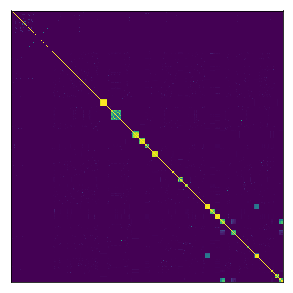

In [31]:

sim_matrix = cosine_similarity(bigram_matrix)
print (sim_matrix.shape)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
right='off', left='off', labelleft='off')
plt.imshow(sim_matrix[sort_ind, :][:,sort_ind])
plt.savefig('../results/sim_matrix.png')

In [39]:
# total_ads_in_clusters = sum(cluster_counts[:k])
total_ads_in_clusters = 0
avg_of_avg_label_scores = sum(avg_label_scores[:k])/k
avg_of_anomaly_scores = sum(suspicious_scores[:k])/k

print ("Total ads in clusters: {}, Average of label scores per cluster: {}, average of anomaly scores per cluster: {}".format(
total_ads_in_clusters, avg_of_avg_label_scores, avg_of_anomaly_scores))

Total ads in clusters: 0, Average of label scores per cluster: 1.775, average of anomaly scores per cluster: 1.987336836097732


In [ ]:
print (pre_)